In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, correlate, correlation_lags, find_peaks_cwt
from scipy.integrate import trapz
from datetime import datetime, timedelta
from vtools.functions.filter import cosine_lanczos
from vtools.data.vtime import days, hours, minutes
import cmocean

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Swap out frk for frk to see if we get better peak behavior

# Load the elevation and salinity data

In [2]:
#load the SCHA filtered signal for Point Reyes 
#use Eli's SCHA filter subtide that I then subtracted the 40 day box car from
ptreyes=pd.read_csv("/global/scratch/users/jennaisrael/time_varying_data/tide_gauge_data/bcfiltered_SCHA_subtide_ptreyes.csv")
dtformat = '%Y-%m-%dT%H:%M:%S'
ptreyes['datetime'] = pd.to_datetime(ptreyes['datetime'],format=dtformat)
pr_filt=ptreyes[['datetime','box_40d_filt']].rename(columns={"box_40d_filt": "Residual"}).dropna()
pr_filt.set_index("datetime",inplace=True)
pr_filt

,Residual
datetime,
2012-02-12 01:30:00,0.057819
2012-02-12 02:00:00,0.059018
2012-02-12 02:30:00,0.060316
2012-02-12 03:00:00,0.061613
2012-02-12 03:30:00,0.062910
...,...
2023-11-19 20:30:00,-0.110012
2023-11-19 21:00:00,-0.109173
2023-11-19 21:30:00,-0.108133


In [3]:
jp=pd.read_csv('/global/scratch/users/jennaisrael/time_varying_data/dmsdatastore/salinity/jp_tidal_40dbc_filt.csv')
jp['datetime']=pd.to_datetime(jp['datetime'],format=dtformat)
jp.set_index("datetime",inplace=True)

frk=pd.read_csv('/global/scratch/users/jennaisrael/time_varying_data/dmsdatastore/salinity/frk_tidal_40dbc_filt.csv')
frk['datetime']=pd.to_datetime(frk['datetime'],format=dtformat)
frk.set_index("datetime",inplace=True)

frk

,S_residual[microS/cm]
datetime,
2015-08-14 04:00:00,45.748348
2015-08-14 04:15:00,45.580851
2015-08-14 04:30:00,45.418091
2015-08-14 04:45:00,45.260075
2015-08-14 05:00:00,45.106802
...,...
2025-05-31 13:00:00,-5.925643
2025-05-31 13:15:00,-5.939119
2025-05-31 13:30:00,-5.952717


# Compute the cross correlations

In [4]:
#need to downsample the salinity data so it is the same frequency as the pr data
jp_ds=jp.resample('30min').mean()
frk_ds=frk.resample('30min').mean()

In [5]:
#then need to trim all the data to be the same period of time
print('PR: '+ str(pr_filt.first_valid_index()) +' - '+ str(pr_filt.last_valid_index()))
print('JP: '+ str(jp_ds.first_valid_index()) +' - '+ str(jp_ds.last_valid_index()))
print('frk: '+ str(frk_ds.first_valid_index()) +' - '+ str(frk_ds.last_valid_index()))

PR: 2012-02-12 01:30:00 - 2023-11-19 22:30:00
JP: 2009-10-12 19:00:00 - 2025-02-06 20:00:00
frk: 2015-08-14 04:00:00 - 2025-05-31 14:00:00


In [6]:
pr_filt

,Residual
datetime,
2012-02-12 01:30:00,0.057819
2012-02-12 02:00:00,0.059018
2012-02-12 02:30:00,0.060316
2012-02-12 03:00:00,0.061613
2012-02-12 03:30:00,0.062910
...,...
2023-11-19 20:30:00,-0.110012
2023-11-19 21:00:00,-0.109173
2023-11-19 21:30:00,-0.108133


In [7]:
# frk starts first pr ends first
pr_filt=pr_filt.loc[frk_ds.first_valid_index():pr_filt.last_valid_index()]
jp_ds=jp_ds.loc[frk_ds.first_valid_index():pr_filt.last_valid_index()]
frk_ds=frk_ds.loc[frk_ds.first_valid_index():pr_filt.last_valid_index()]

In [8]:
pr_filt

,Residual
datetime,
2015-08-14 04:00:00,-0.050736
2015-08-14 04:30:00,-0.051259
2015-08-14 05:00:00,-0.051782
2015-08-14 05:30:00,-0.052305
2015-08-14 06:00:00,-0.052829
...,...
2023-11-19 20:30:00,-0.110012
2023-11-19 21:00:00,-0.109173
2023-11-19 21:30:00,-0.108133


In [9]:
#now just extract the values
pr_ds=pr_filt.Residual.values
jp_ds=jp_ds['S_residual[microS/cm]'].values
frk_ds=frk_ds['S_residual[microS/cm]'].values

In [10]:
len(jp_ds)

144950

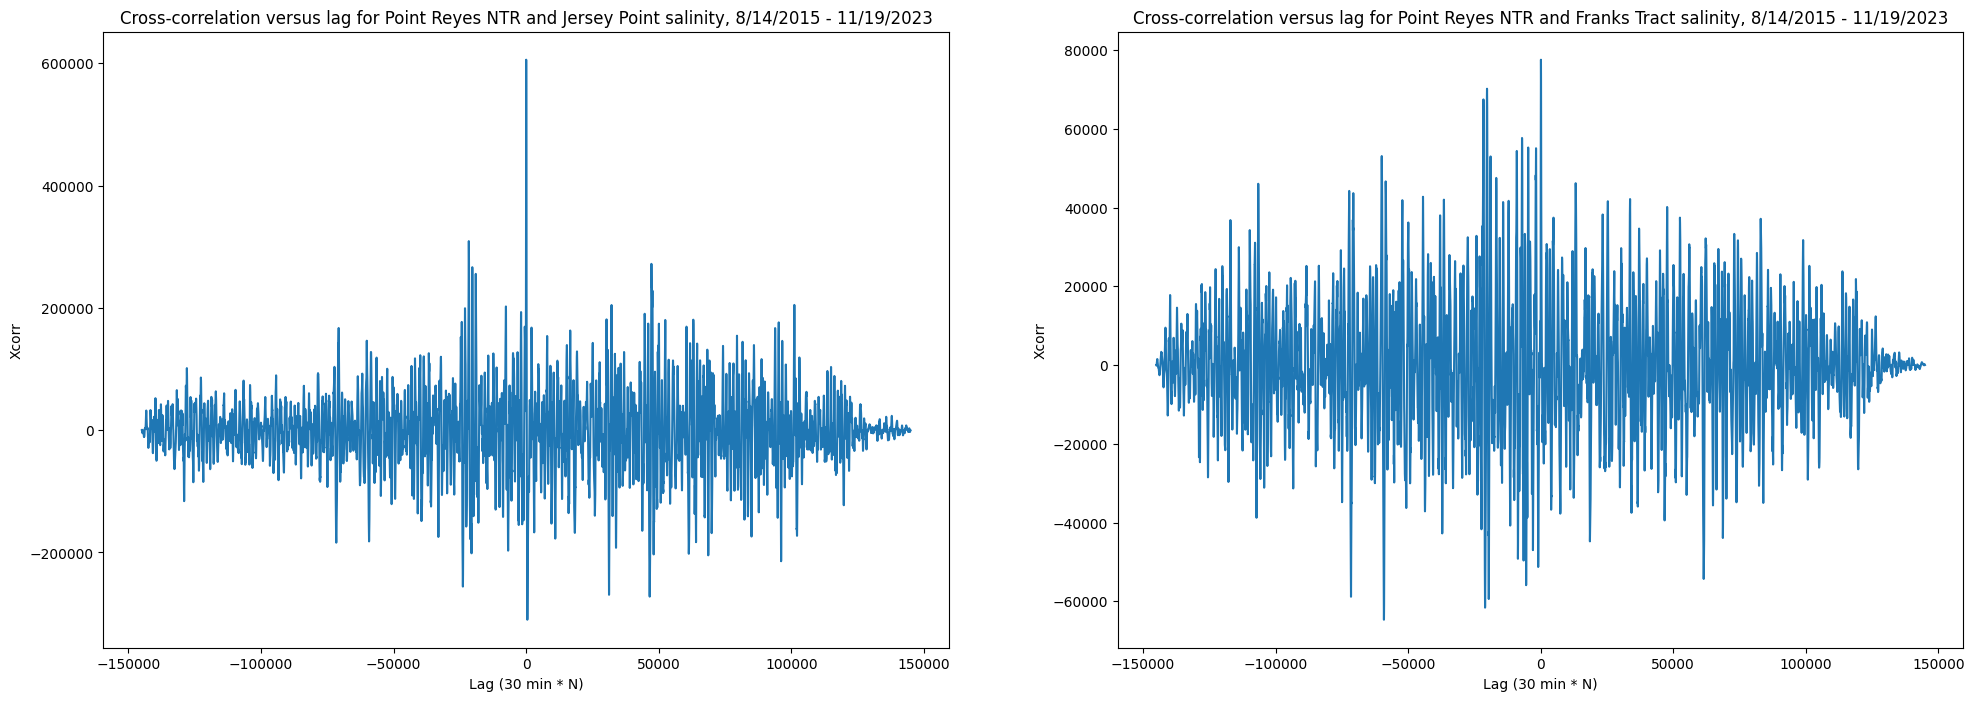

Lag of max cross-correlation for Jersey Point is 13.5 hours
Lag of max cross-correlation for Franks Tract is 49.0 hours


In [11]:
# compute the  cross correlations
corrjp = correlate(jp_ds,pr_ds)
lagsjp = correlation_lags(len(jp_ds),len(pr_ds))
corrfrk = correlate(frk_ds,pr_ds)
lagsfrk = correlation_lags(len(frk_ds),len(pr_ds))

fig, ax= plt.subplots(1,2,figsize=(24,8))
ax[0].plot(lagsjp,corrjp)
ax[0].set_xlabel('Lag (30 min * N)')
ax[0].set_ylabel('Xcorr')
ax[0].set_title('Cross-correlation versus lag for Point Reyes NTR and Jersey Point salinity, 8/14/2015 - 11/19/2023')

ax[1].plot(lagsfrk,corrfrk)
ax[1].set_xlabel('Lag (30 min * N)')
ax[1].set_ylabel('Xcorr')
ax[1].set_title('Cross-correlation versus lag for Point Reyes NTR and Franks Tract salinity, 8/14/2015 - 11/19/2023')
plt.show()
print('Lag of max cross-correlation for Jersey Point is '+ str(lagsjp[corrjp.argmax()]*0.5)+ ' hours')
print('Lag of max cross-correlation for Franks Tract is '+ str(lagsfrk[corrfrk.argmax()]*0.5)+ ' hours')

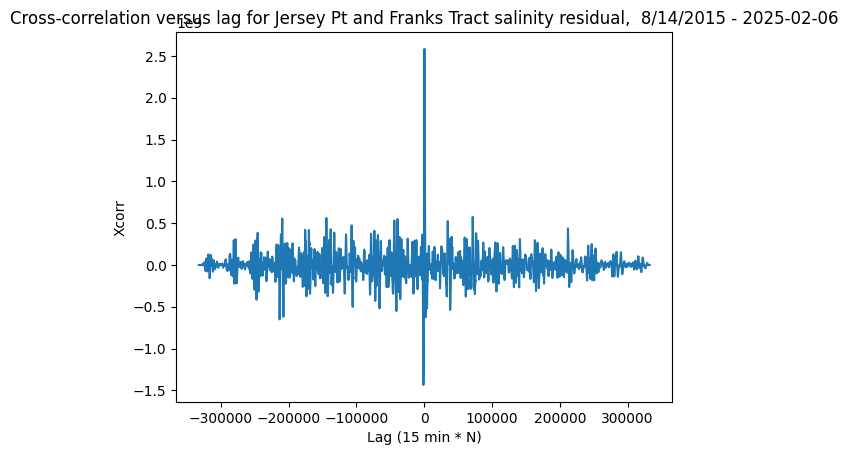

Lag of max cross-correlation for period 1 is 57.75 hours


In [12]:
# What about the correlation between JP and frk
#do not down sample
#first trim frk starts later and JP ends first, but maybe constrain time frame to when the Pt reyes data is 
# jp_trim=jp.loc[frk.first_valid_index():jp.last_valid_index()]
# frk_trim=frk.loc[frk.first_valid_index():jp.last_valid_index()]
jp_trim=jp.loc[frk.first_valid_index():jp.last_valid_index()]
frk_trim=frk.loc[frk.first_valid_index():jp.last_valid_index()]
# compute the  cross correlations
corrjh = correlate(frk_trim,jp_trim)
lagsjh = correlation_lags(len(frk_trim),len(jp_trim))

fig, ax= plt.subplots()
ax.plot(lagsjh,corrjh)
ax.set_xlabel('Lag (15 min * N)')
ax.set_ylabel('Xcorr')
ax.set_title('Cross-correlation versus lag for Jersey Pt and Franks Tract salinity residual,  8/14/2015 - 2025-02-06')

plt.show()
print('Lag of max cross-correlation for period 1 is '+ str(lagsjh[corrjh.argmax()]*0.25)+ ' hours')


# Combine data into a single dataframe

In [13]:
#put all the variables in one array, need to cut it off before the last array begins (pr 2012-02-12) and before the first array ends (pr 2023-11-19)
df_raw=pd.concat([pr_filt.rename(columns={"Residual": "pr"}),jp.rename(columns={"S_residual[microS/cm]": "jp"}),frk.rename(columns={"S_residual[microS/cm]": "frk"})],axis=1)
df=df_raw.loc[frk.first_valid_index():pr_filt.last_valid_index()]#.interpolate()

In [14]:
df['datetime']=df.index.values
df['month']=df.index.month.values
df['year']=df.index.year.values

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a c

In [15]:
df

,pr,jp,frk,datetime,month,year
datetime,,,,,,
2015-08-14 04:00:00,-0.050736,26.855121,45.748348,2015-08-14 04:00:00,8,2015
2015-08-14 04:15:00,NaN,25.240327,45.580851,2015-08-14 04:15:00,8,2015
2015-08-14 04:30:00,-0.051259,23.601701,45.418091,2015-08-14 04:30:00,8,2015
2015-08-14 04:45:00,NaN,21.939668,45.260075,2015-08-14 04:45:00,8,2015
2015-08-14 05:00:00,-0.051782,20.254665,45.106802,2015-08-14 05:00:00,8,2015
...,...,...,...,...,...,...
2023-11-19 21:30:00,-0.108133,-120.933964,-25.989246,2023-11-19 21:30:00,11,2023
2023-11-19 21:45:00,NaN,-124.697347,-26.261633,2023-11-19 21:45:00,11,2023
2023-11-19 22:00:00,-0.107092,-128.355330,-26.534047,2023-11-19 22:00:00,11,2023


In [16]:
# maybe skip the masking for now
df_f_wo21=df.mask((df['month']<7))# |(df['year']==2021)|(df['year']==2022)) #try leaving in december

In [17]:
# df_f_wo21=df.copy()

# Try peak finding now (no minimum prominence)

In [45]:
#control on min and max length of event
maxw=30*24*4 #60*24*4
minw=2
#how far to search for an event beyond the point reyes peak
win=26 #in hours
winh=60 #in hours
#example
# x2=x+pd.Timedelta(hours=win)
# x3=x+pd.Timedelta(hours=winh)

In [46]:
#first find the datetimes with peaks at all locations, store them in logical columns e.g. pr_peak
#seems to be using the whole summer as a peak sometimes, set max width of 2 months 

peakspr, propertiespr = find_peaks(df_f_wo21.pr.dropna().values, height=0,width=(2,maxw))#,width=(0,maxw)) #this just gives the x locations of the peaks, need to convert to logical
pr_indices = df_f_wo21.pr.dropna().index
peaksjp, propertiesjp = find_peaks(df_f_wo21.jp.dropna().values,width=(0,maxw)) #prominence=10,
jp_indices = df_f_wo21.jp.dropna().index
peaksfrk, propertiesfrk = find_peaks(df_f_wo21.frk.dropna().values,width=(0,maxw)) #prominence=5
frk_indices = df_f_wo21.frk.dropna().index
# peaksfrk, propertiesfrk = find_peaks(df_f_wo21.frk.dropna().values, prominence=5,width=(0,maxw))
# frk_indices = df_f_wo21.frk.dropna().index
#peaksfrk10, _ = find_peaks(df_f_wo21.frk.values, prominence=10)
idx=np.arange(0,len(df_f_wo21.pr.values))#has the same shape as the first argument
df_f_wo21['pr_peak']=np.isin(df_f_wo21.index,pr_indices[peakspr]) #for this one need to map from the nan dropped list to full list
df_f_wo21['jp_peak']=np.isin(df_f_wo21.index,jp_indices[peaksjp])
df_f_wo21['frk_peak']=np.isin(df_f_wo21.index,frk_indices[peaksfrk])
#df_f_wo21['frk_peak']=np.isin(df_f_wo21.index,frk_indices[peaksfrk])
df_f_wo21

,pr,jp,frk,datetime,month,year,pr_peak,jp_peak,frk_peak
datetime,,,,,,,,,
2015-08-14 04:00:00,-0.050736,26.855121,45.748348,2015-08-14 04:00:00,8.0,2015.0,False,False,False
2015-08-14 04:15:00,NaN,25.240327,45.580851,2015-08-14 04:15:00,8.0,2015.0,False,False,False
2015-08-14 04:30:00,-0.051259,23.601701,45.418091,2015-08-14 04:30:00,8.0,2015.0,False,False,False
2015-08-14 04:45:00,NaN,21.939668,45.260075,2015-08-14 04:45:00,8.0,2015.0,False,False,False
2015-08-14 05:00:00,-0.051782,20.254665,45.106802,2015-08-14 05:00:00,8.0,2015.0,False,False,False
...,...,...,...,...,...,...,...,...,...
2023-11-19 21:30:00,-0.108133,-120.933964,-25.989246,2023-11-19 21:30:00,11.0,2023.0,False,False,False
2023-11-19 21:45:00,NaN,-124.697347,-26.261633,2023-11-19 21:45:00,11.0,2023.0,False,False,False
2023-11-19 22:00:00,-0.107092,-128.355330,-26.534047,2023-11-19 22:00:00,11.0,2023.0,False,False,False


In [47]:
print(df_f_wo21['pr_peak'].sum())
print(df_f_wo21['jp_peak'].sum())
#print(df_f_wo21['frk_peak'].sum())
print(df_f_wo21['frk_peak'].sum())

315
333
316


In [48]:
# plt.plot(frk_indices[peaksfrk].year.

# Are we catching all the peaks?

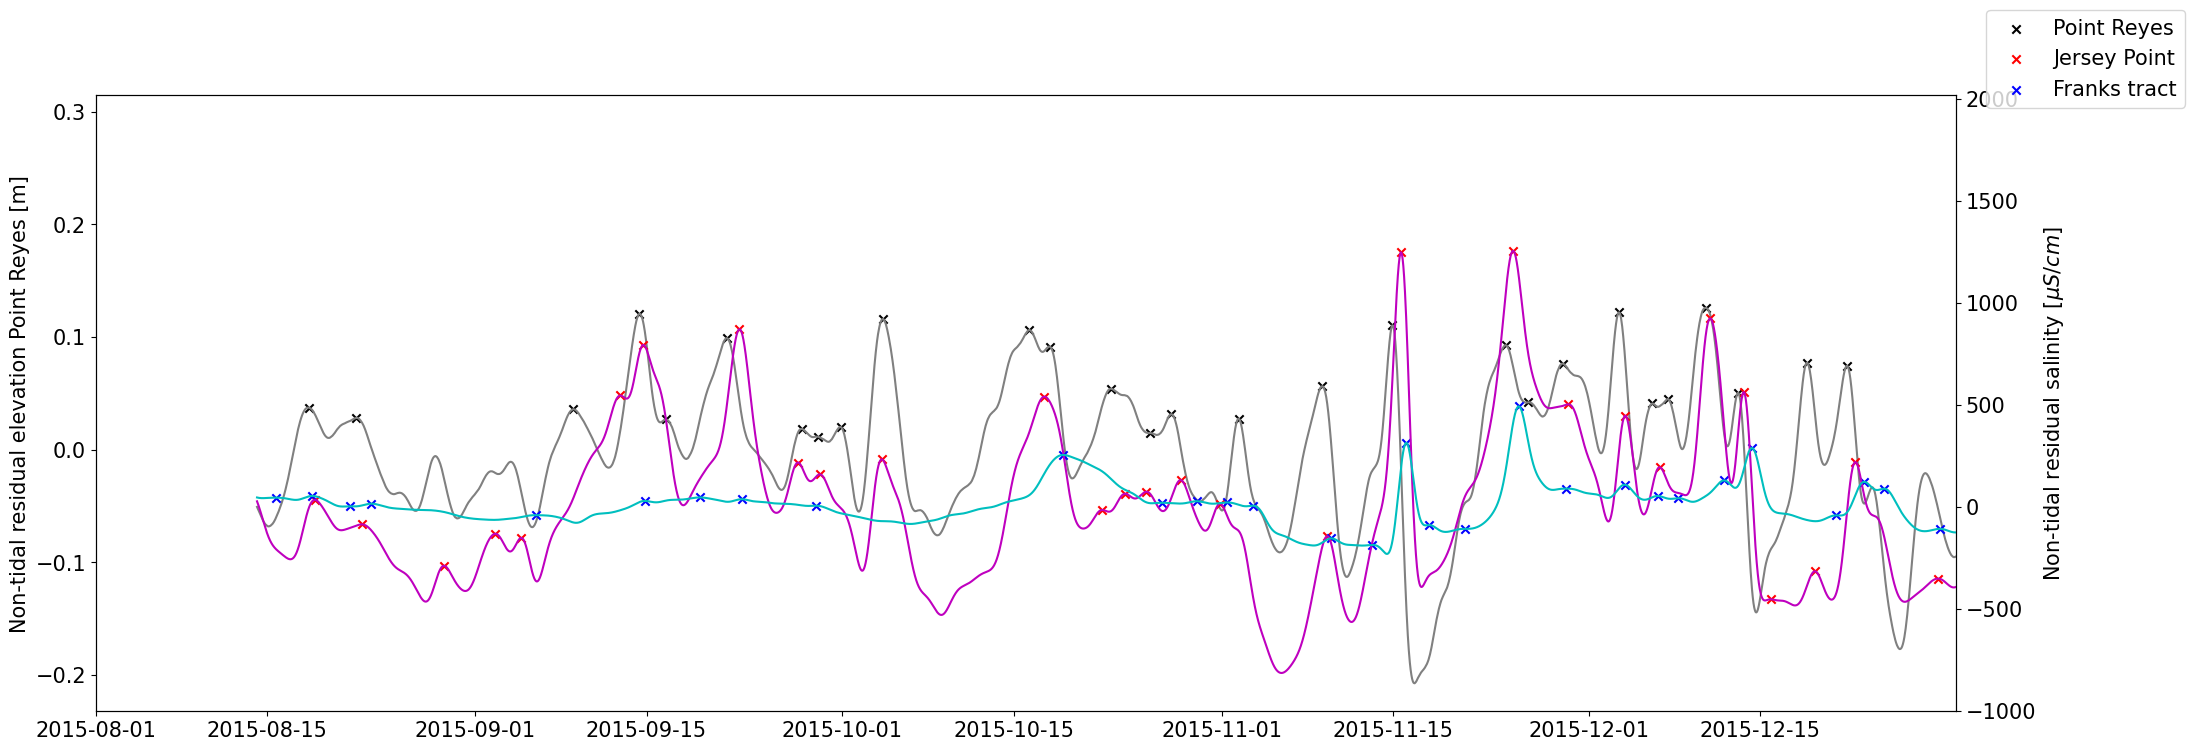

In [49]:
fig, ax =plt.subplots(figsize=(24,8))

ax.plot(pr_indices,df_f_wo21.pr.dropna(),color='grey')
ax.scatter(pr_indices[peakspr], df_f_wo21.pr.dropna().iloc[peakspr], label="Point Reyes",marker="x",color='k')
ax1=ax.twinx()
ax1.plot(df_f_wo21.jp,color='m')
ax1.scatter(jp_indices[peaksjp],df_f_wo21.jp.loc[jp_indices[peaksjp]],label="Jersey Point",marker="x",color='r')
# ax1.plot(df_f_wo21.frk,color='g')
# ax1.scatter(df_f_wo21.datetime.iloc[peaksfrk],df_f_wo21.frk.iloc[peaksfrk],label="Franks Tract",marker="x",color='darkgreen')
ax1.plot(df_f_wo21.frk,color='c')
ax1.scatter(frk_indices[peaksfrk],df_f_wo21.frk.loc[frk_indices[peaksfrk]],label="Franks tract",marker="x",color='b')

ax.set_ylabel('Non-tidal residual elevation Point Reyes [m]')
ax1.set_ylabel('Non-tidal residual salinity [$\mu S/cm$]')
fig.legend()
ax.set_xlim([datetime(2015,8,1),datetime(2015,12,31)])
ax1.set_xlim([datetime(2015,8,1),datetime(2015,12,31)])
plt.show()

(17744.0, 17896.0)

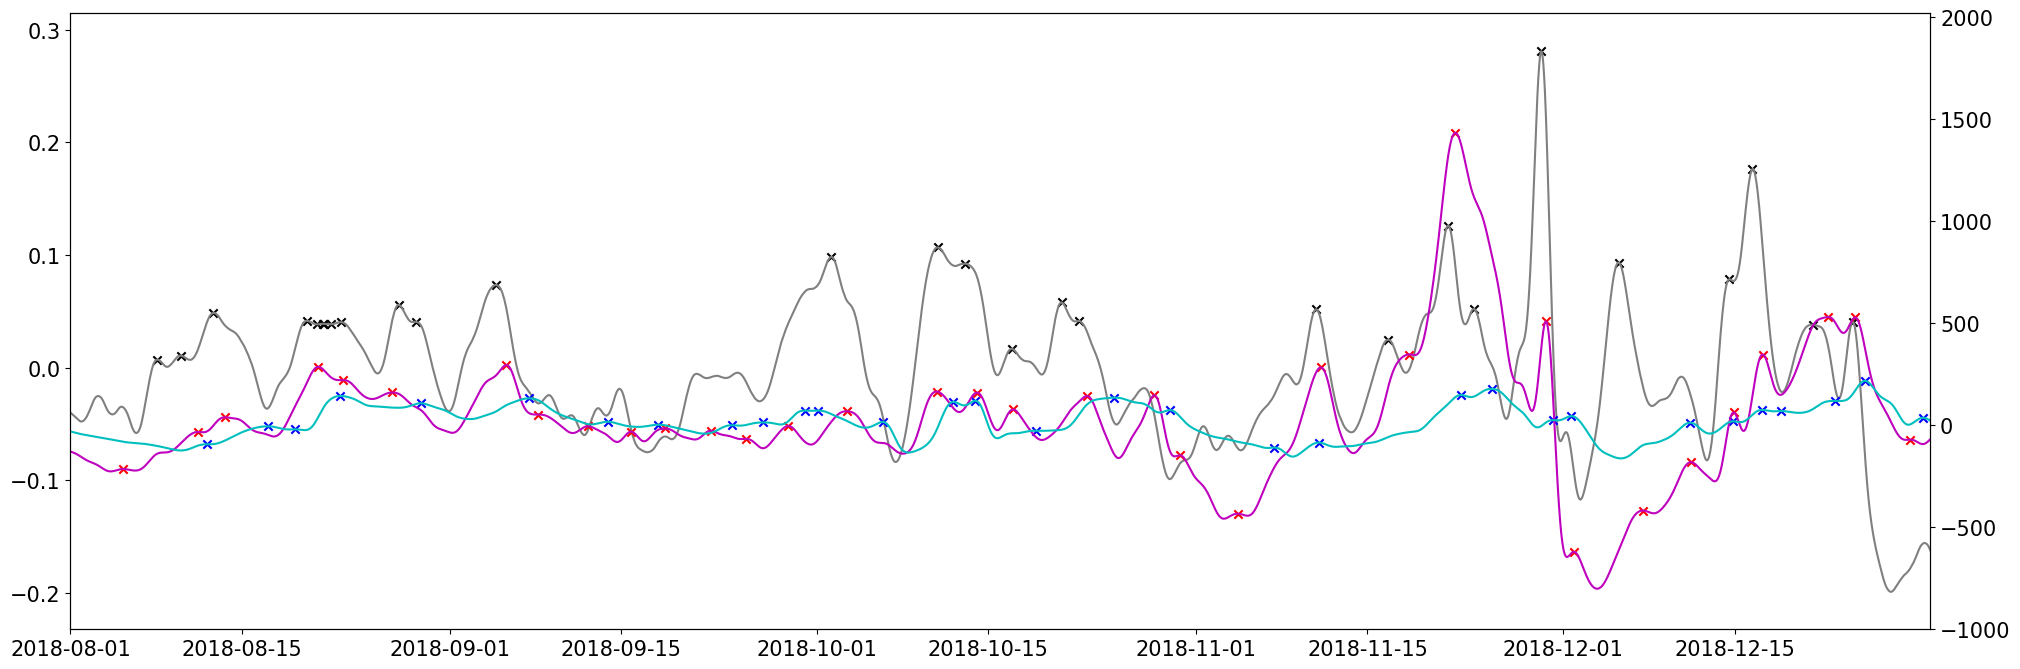

In [59]:
fig, ax =plt.subplots(figsize=(24,8))

ax.plot(pr_indices,df_f_wo21.pr.dropna(),color='grey')
ax.scatter(pr_indices[peakspr], df_f_wo21.pr.dropna().iloc[peakspr], label="Point Reyes",marker="x",color='k')
ax1=ax.twinx()
ax1.plot(df_f_wo21.jp,color='m')
ax1.scatter(jp_indices[peaksjp],df_f_wo21.jp.loc[jp_indices[peaksjp]],label="Jersey Point",marker="x",color='r')
# ax1.plot(df_f_wo21.frk,color='g')
# ax1.scatter(df_f_wo21.datetime.iloc[peaksfrk],df_f_wo21.frk.iloc[peaksfrk],label="Franks Tract",marker="x",color='darkgreen')
ax1.plot(df_f_wo21.frk,color='c')
ax1.scatter(frk_indices[peaksfrk],df_f_wo21.frk.loc[frk_indices[peaksfrk]],label="Holland Cut",marker="x",color='b')

ax.set_xlim([datetime(2018,8,1),datetime(2018,12,31)])
ax1.set_xlim([datetime(2018,8,1),datetime(2018,12,31)])

(18475.0, 18627.0)

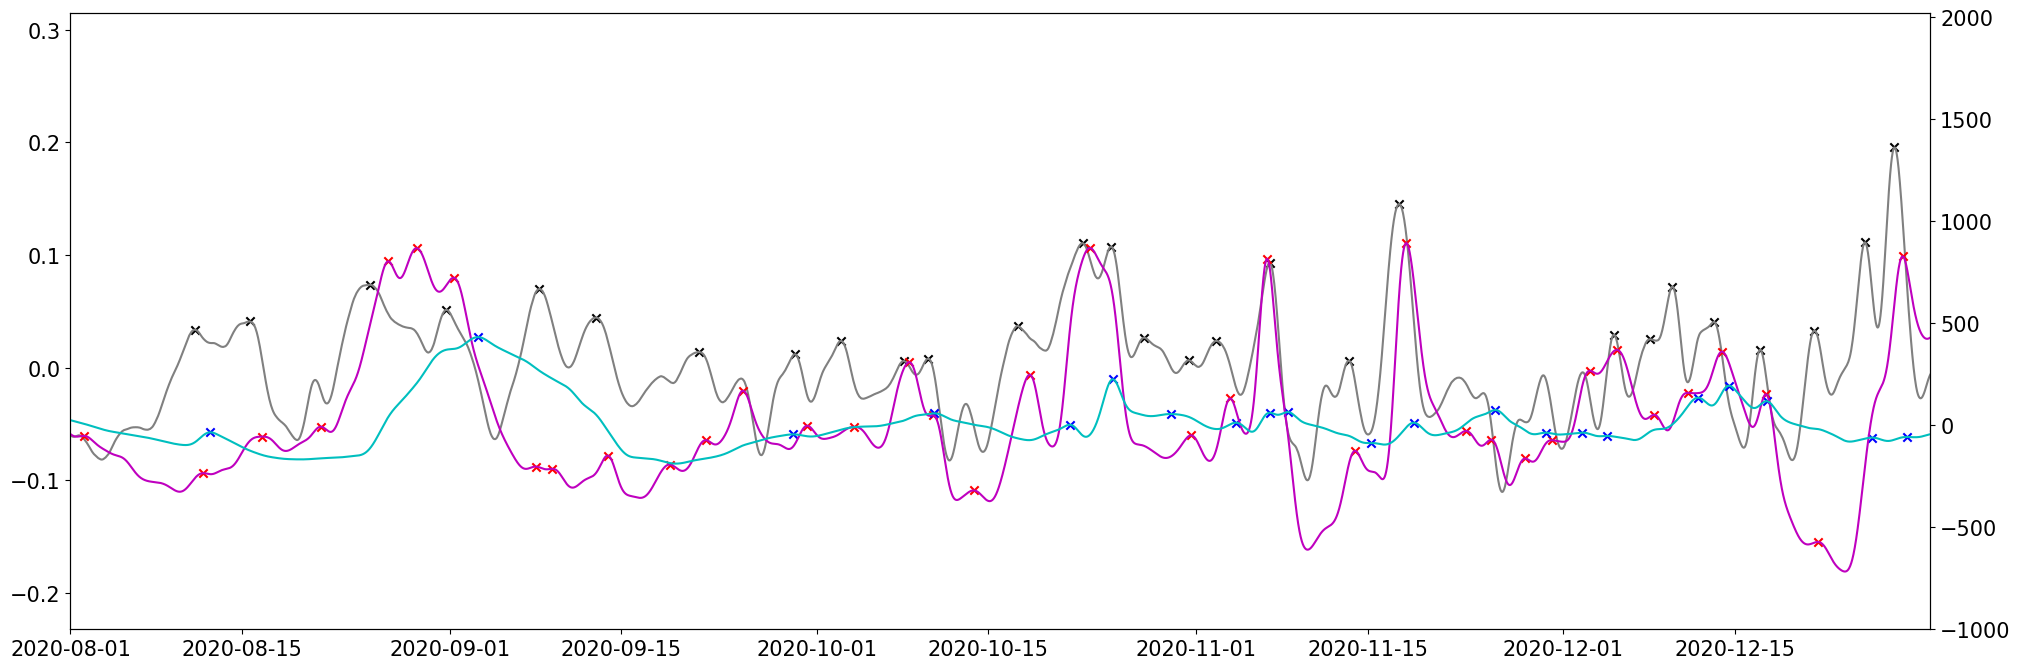

In [60]:
fig, ax =plt.subplots(figsize=(24,8))

ax.plot(pr_indices,df_f_wo21.pr.dropna(),color='grey')
ax.scatter(pr_indices[peakspr], df_f_wo21.pr.dropna().iloc[peakspr], label="Point Reyes",marker="x",color='k')
ax1=ax.twinx()
ax1.plot(df_f_wo21.jp,color='m')
ax1.scatter(jp_indices[peaksjp],df_f_wo21.jp.loc[jp_indices[peaksjp]],label="Jersey Point",marker="x",color='r')
# ax1.plot(df_f_wo21.frk,color='g')
# ax1.scatter(df_f_wo21.datetime.iloc[peaksfrk],df_f_wo21.frk.iloc[peaksfrk],label="Franks Tract",marker="x",color='darkgreen')
ax1.plot(df_f_wo21.frk,color='c')
ax1.scatter(frk_indices[peaksfrk],df_f_wo21.frk.loc[frk_indices[peaksfrk]],label="Holland Cut",marker="x",color='b')

ax.set_xlim([datetime(2020,8,1),datetime(2020,12,31)])
ax1.set_xlim([datetime(2020,8,1),datetime(2020,12,31)])

(18550.0, 18567.0)

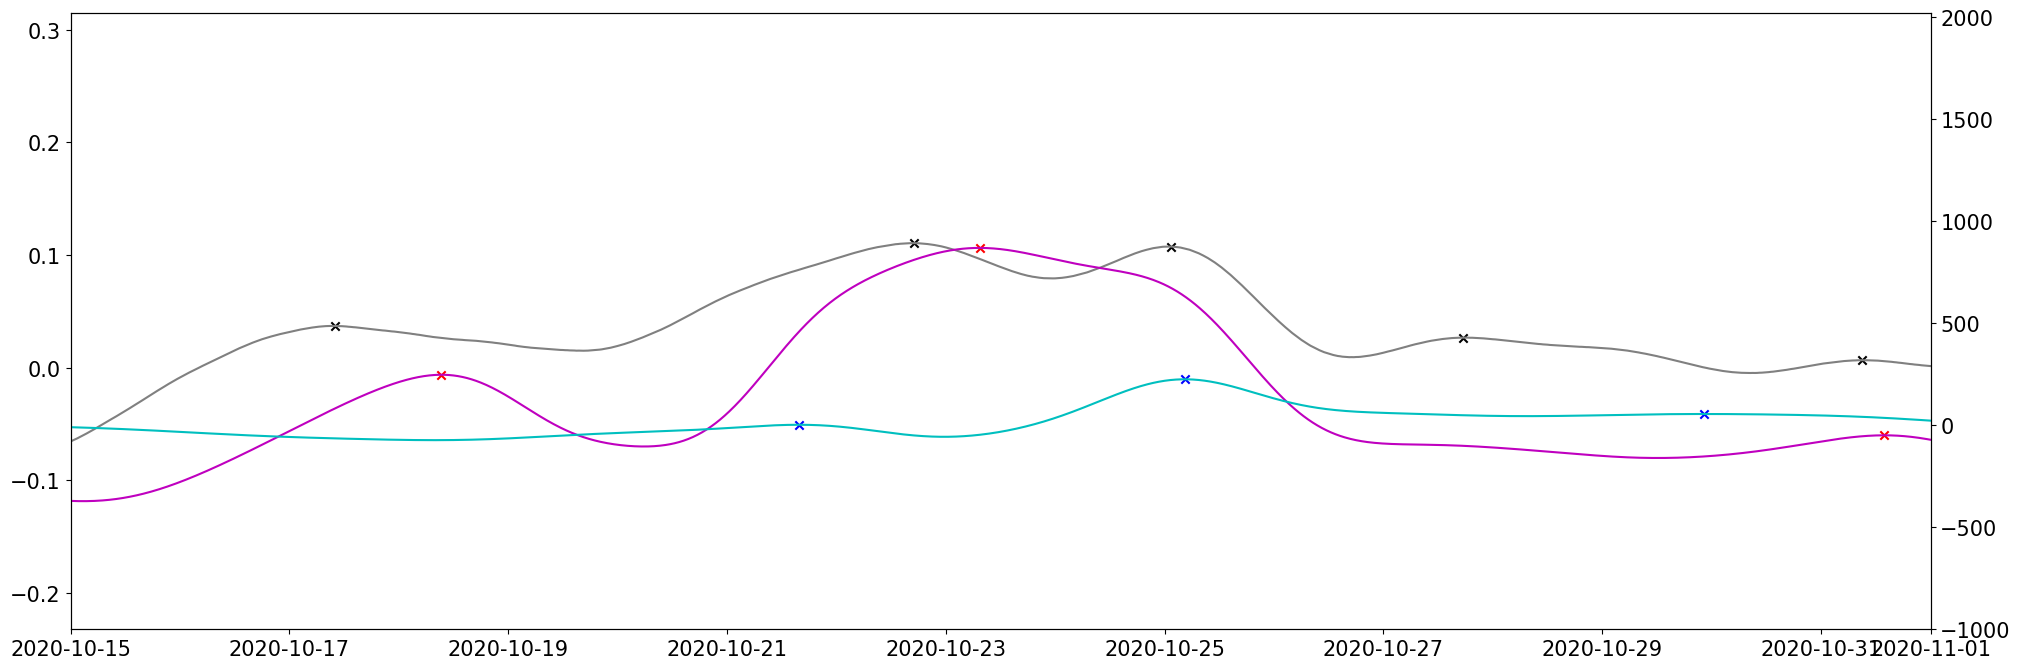

In [61]:
fig, ax =plt.subplots(figsize=(24,8))

ax.plot(pr_indices,df_f_wo21.pr.dropna(),color='grey')
ax.scatter(pr_indices[peakspr], df_f_wo21.pr.dropna().iloc[peakspr], label="Point Reyes",marker="x",color='k')
ax1=ax.twinx()
ax1.plot(df_f_wo21.jp,color='m')
ax1.scatter(jp_indices[peaksjp],df_f_wo21.jp.loc[jp_indices[peaksjp]],label="Jersey Point",marker="x",color='r')
# ax1.plot(df_f_wo21.frk,color='g')
# ax1.scatter(df_f_wo21.datetime.iloc[peaksfrk],df_f_wo21.frk.iloc[peaksfrk],label="Franks Tract",marker="x",color='darkgreen')
ax1.plot(df_f_wo21.frk,color='c')
ax1.scatter(frk_indices[peaksfrk],df_f_wo21.frk.loc[frk_indices[peaksfrk]],label="Holland Cut",marker="x",color='b')

ax.set_xlim([datetime(2020,10,15),datetime(2020,11,1)])
ax1.set_xlim([datetime(2020,10,15),datetime(2020,11,1)])

# Filter peaks

In [62]:
#make an array of ones to multiply by the true false
ov=np.ones_like(df_f_wo21['pr_peak'].values)

In [82]:
# as a first pass, how many events are there where there is a true value in all columns in the 24 hours after the pr peak?
peak_pr24h_1=np.datetime64()
peak_jp24h_1=np.datetime64()
peak_frk24h=np.datetime64()

# win=24 #number of samples in 24 hours
# winh=win*5
count_j=0
count_h=0
count_dup=0
dup_ind=np.array([]) #indices of the filtered peaks that are the same 
old_frk_time=pr_indices[0]
for p in peakspr:
    #need to map this index back to the data frame
    x=pr_indices[p]
    x2=x+pd.Timedelta(hours=win)
    x3=x+pd.Timedelta(hours=winh)
    if df_f_wo21.jp_peak[x:x2].sum()>0:
        jp_time=(x+pd.Timedelta(minutes=df_f_wo21.jp_peak[x:x2].argmax()*15)).to_datetime64()
        count_j=count_j+1
        if df_f_wo21.frk_peak[x:x3].sum()>0: 
            frk_time=(x+pd.Timedelta(minutes=df_f_wo21.frk_peak[x:x3].argmax()*15)).to_datetime64()
            if frk_time>jp_time: #and old_frk_time!=frk_time: #don't save the duplicate events
                count_h=count_h+1
                peak_pr24h_1=np.append(peak_pr24h_1,x.to_datetime64())
                #these should be in real time (don't drop na)
                peak_jp24h_1=np.append(peak_jp24h_1,jp_time)
                peak_frk24h=np.append(peak_frk24h,frk_time)
                if old_frk_time==frk_time:
                    count_dup=count_dup+1
                    dup_ind=np.append(dup_ind,int(count_h)) #of the N peaks that make it in, these ones are the second peaks, to be excluded later if necessary
                old_frk_time=frk_time
idx=np.arange(0,len(df_f_wo21.pr.values))

print(count_j)
print(count_h)
print(count_dup)
#df_f_wo21['all_peak_24h']=np.isin(idx,peak_pr24h)

156
80
1


In [64]:
#trim the NaT from the beginning of the arrays
peak_pr24h_1=peak_pr24h_1[1:]
#peak_pr24h_2=peak_pr24h_2[1:]
peak_jp24h_1=peak_jp24h_1[1:]
#peak_jp24h_2=peak_jp24h_2[1:]
peak_frk24h=peak_frk24h[1:]
#peak_frk24h=peak_frk24h[1:]

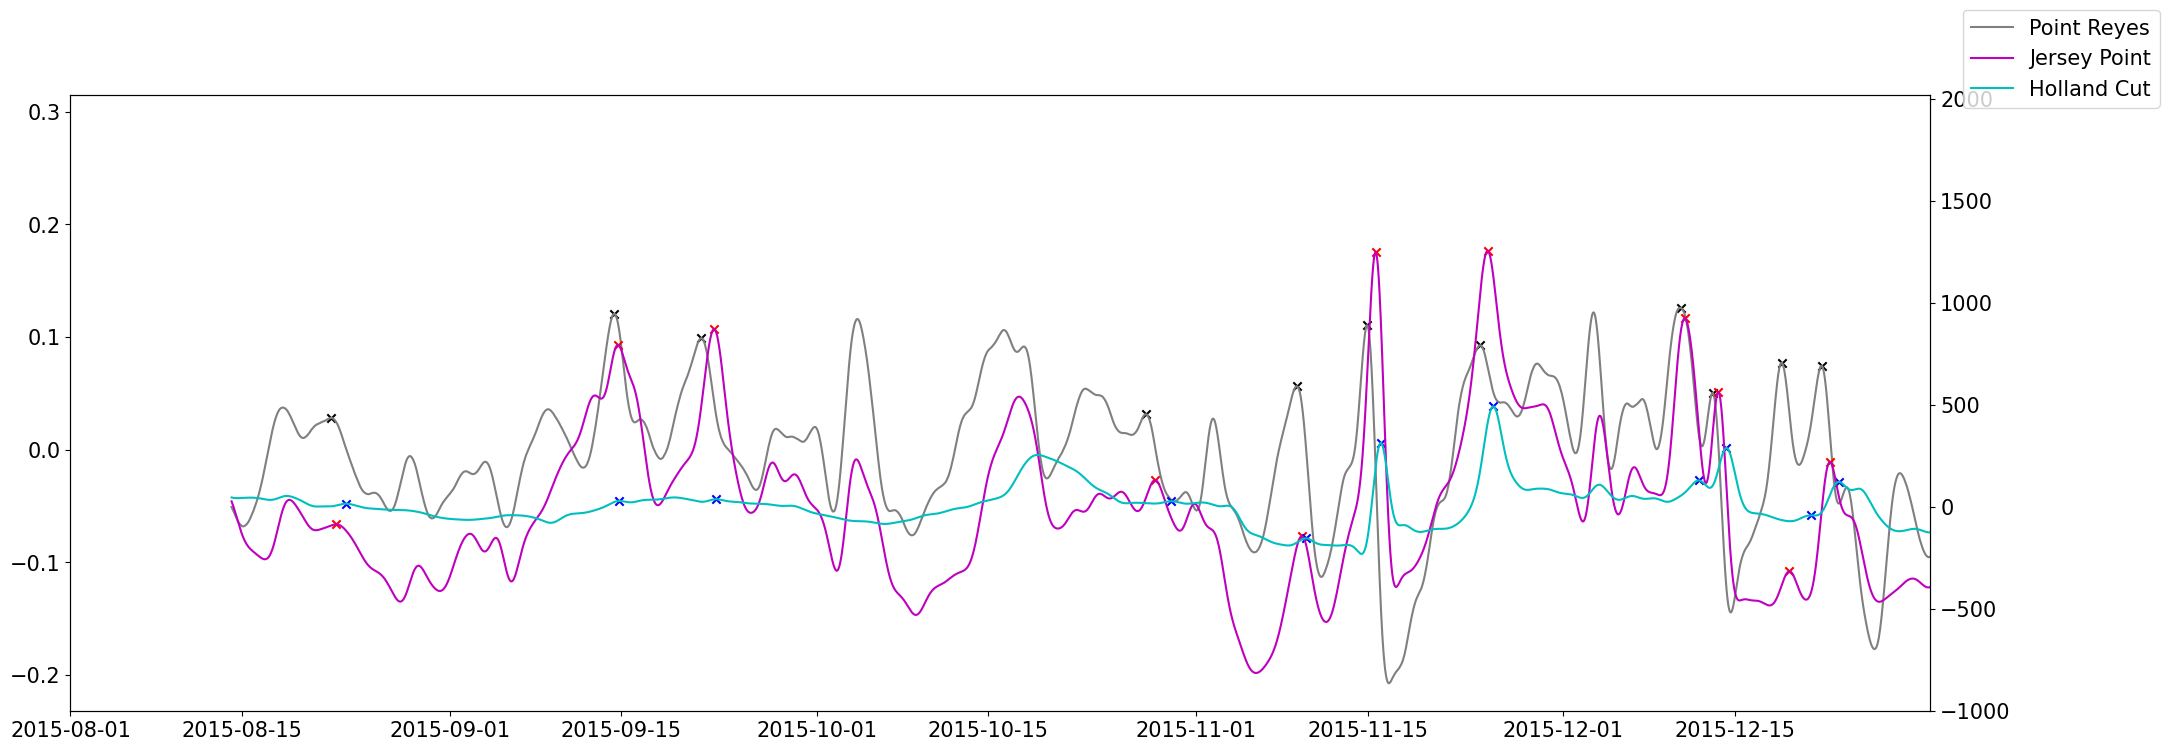

In [65]:
#Zoom into 2015
fig, ax =plt.subplots(sharey=True,figsize=(24,8))

ax.plot(pr_indices,df_f_wo21.pr.dropna(),color='grey', label="Point Reyes")
ax.scatter(df_f_wo21.datetime.loc[peak_pr24h_1], df_f_wo21.pr.loc[peak_pr24h_1],marker="x",color='k')
ax1=ax.twinx()
ax1.plot(df_f_wo21.jp,color='m',label="Jersey Point")
ax1.scatter(df_f_wo21.datetime.loc[peak_jp24h_1],df_f_wo21.jp.loc[peak_jp24h_1],marker="x",color='r')
ax1.plot(df_f_wo21.frk,color='c',label="Holland Cut")
ax1.scatter(df_f_wo21.datetime.loc[peak_frk24h],df_f_wo21.frk.loc[peak_frk24h],marker="x",color='b')
fig.legend()
ax.set_xlim([datetime(2015,8,1),datetime(2015,12,31)])
ax1.set_xlim([datetime(2015,8,1),datetime(2015,12,31)])
plt.show()

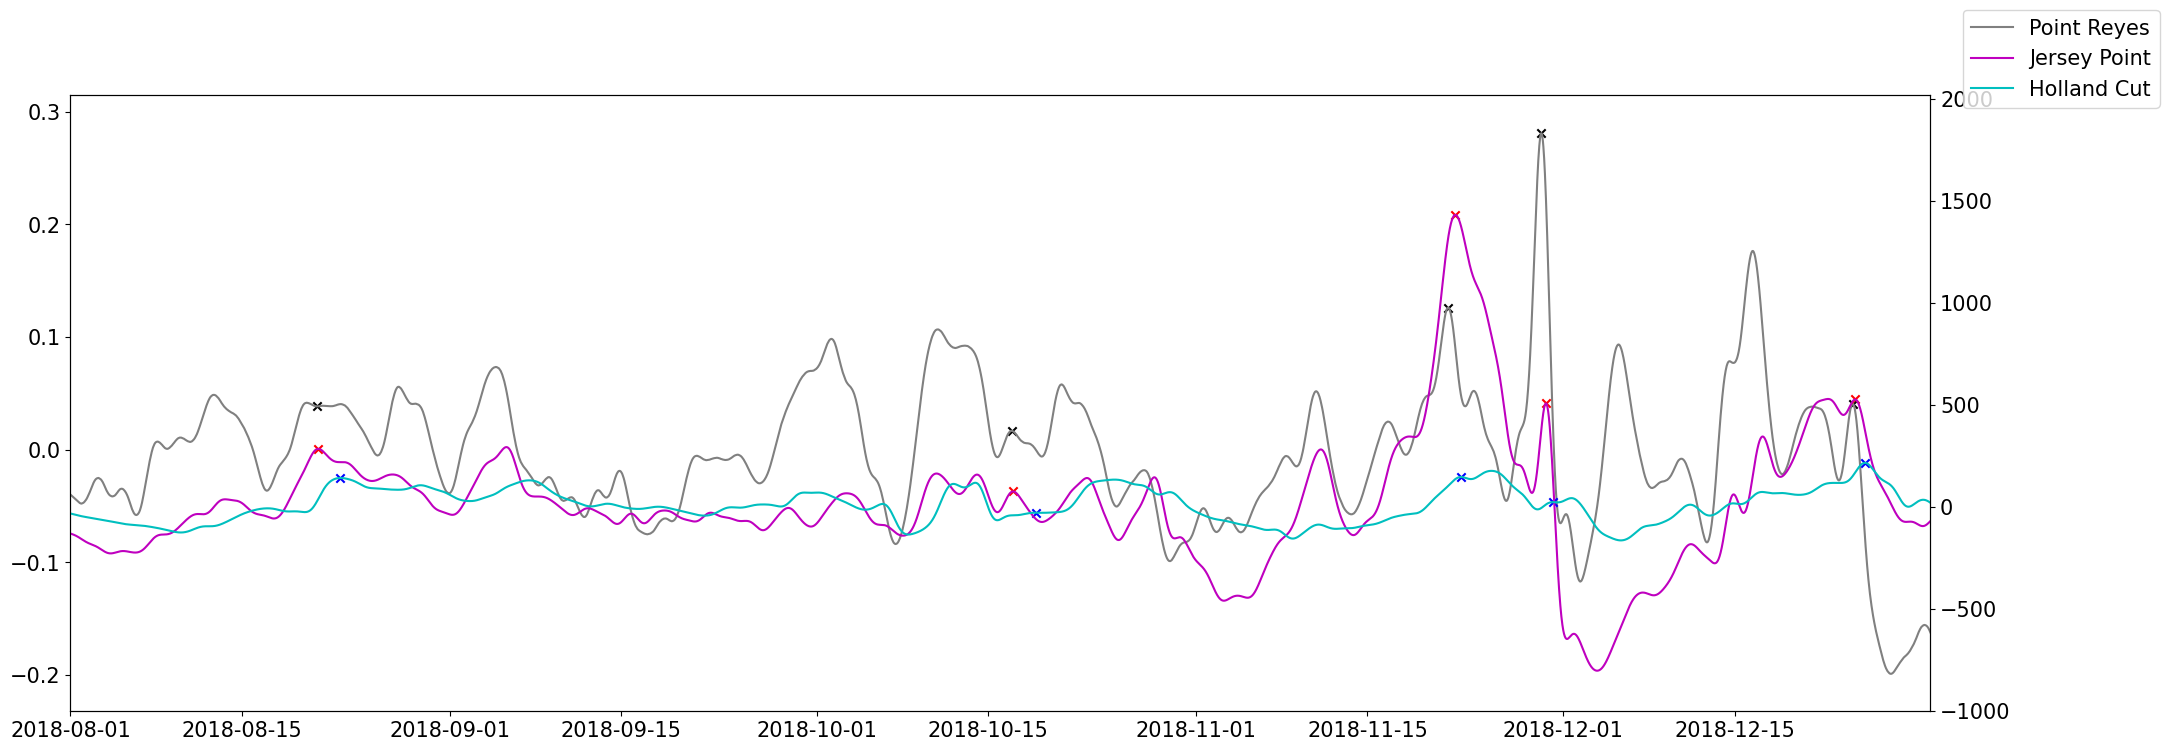

In [66]:
#Zoom into 2015
fig, ax =plt.subplots(sharey=True,figsize=(24,8))

ax.plot(pr_indices,df_f_wo21.pr.dropna(),color='grey', label="Point Reyes")
ax.scatter(df_f_wo21.datetime.loc[peak_pr24h_1], df_f_wo21.pr.loc[peak_pr24h_1],marker="x",color='k')
ax1=ax.twinx()
ax1.plot(df_f_wo21.jp,color='m',label="Jersey Point")
ax1.scatter(df_f_wo21.datetime.loc[peak_jp24h_1],df_f_wo21.jp.loc[peak_jp24h_1],marker="x",color='r')
ax1.plot(df_f_wo21.frk,color='c',label="Holland Cut")
ax1.scatter(df_f_wo21.datetime.loc[peak_frk24h],df_f_wo21.frk.loc[peak_frk24h],marker="x",color='b')
fig.legend()
ax.set_xlim([datetime(2018,8,1),datetime(2018,12,31)])
ax1.set_xlim([datetime(2018,8,1),datetime(2018,12,31)])
plt.show()

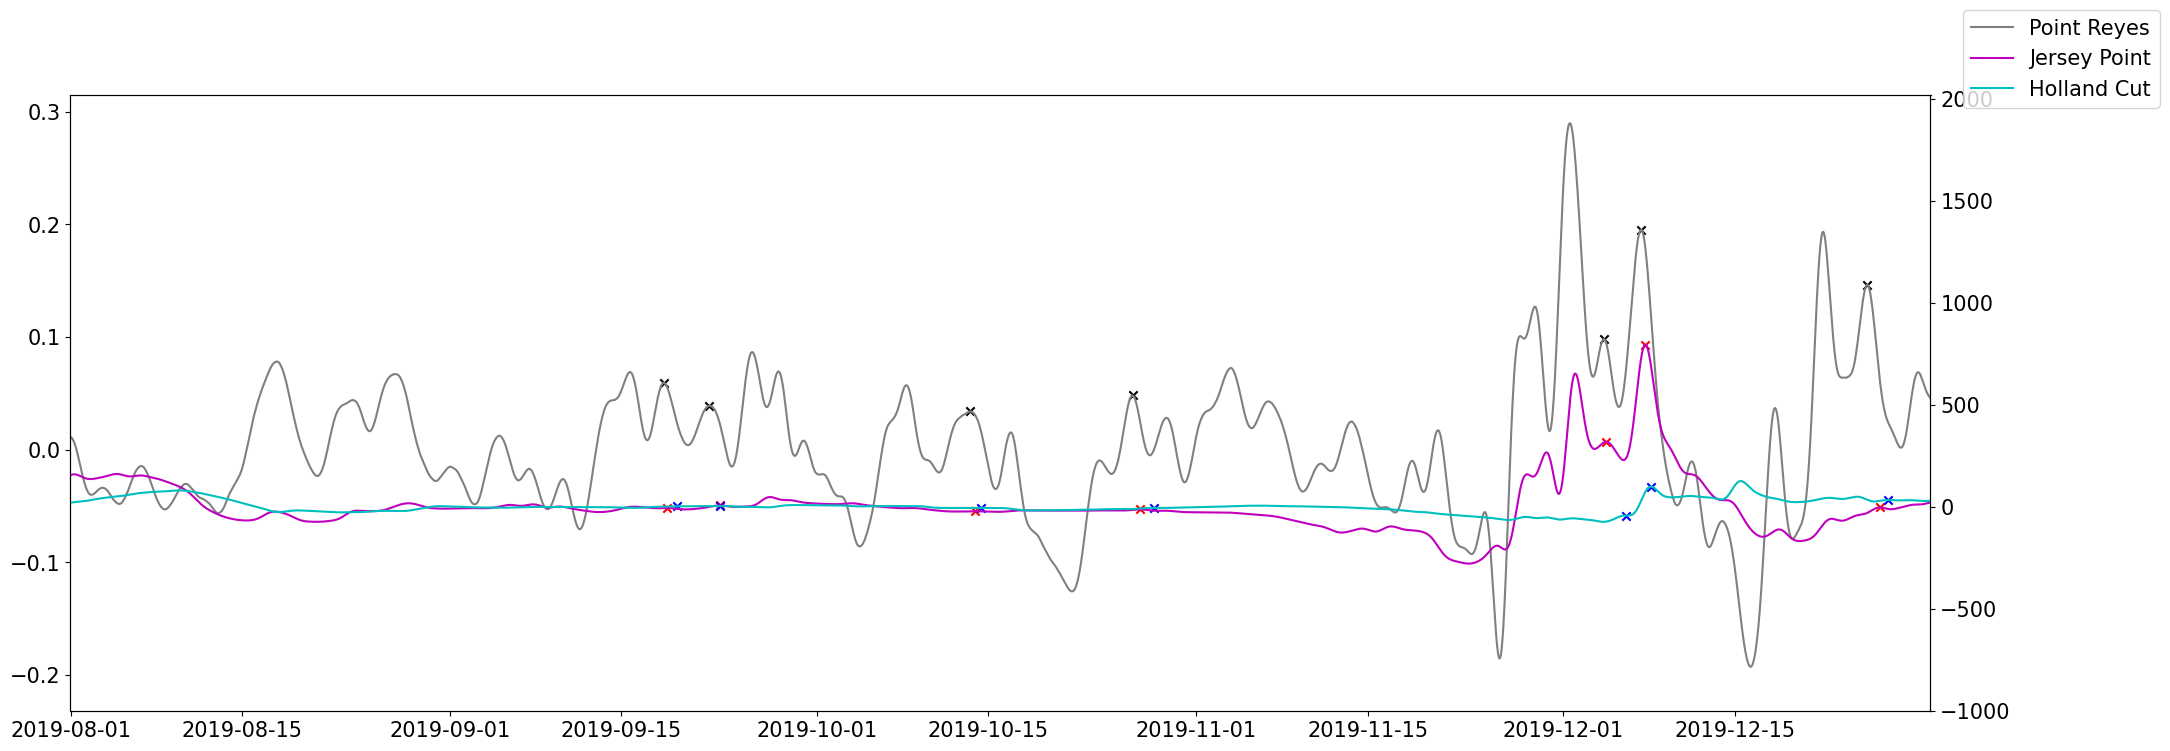

In [67]:
#Zoom into 2012
fig, ax =plt.subplots(sharey=True,figsize=(24,8))

ax.plot(pr_indices,df_f_wo21.pr.dropna(),color='grey', label="Point Reyes")
ax.scatter(df_f_wo21.datetime.loc[peak_pr24h_1], df_f_wo21.pr.loc[peak_pr24h_1],marker="x",color='k')
ax1=ax.twinx()
ax1.plot(df_f_wo21.jp,color='m',label="Jersey Point")
ax1.scatter(df_f_wo21.datetime.loc[peak_jp24h_1],df_f_wo21.jp.loc[peak_jp24h_1],marker="x",color='r')
ax1.plot(df_f_wo21.frk,color='c',label="Holland Cut")
ax1.scatter(df_f_wo21.datetime.loc[peak_frk24h],df_f_wo21.frk.loc[peak_frk24h],marker="x",color='b')
fig.legend()
ax.set_xlim([datetime(2019,8,1),datetime(2019,12,31)])
ax1.set_xlim([datetime(2019,8,1),datetime(2019,12,31)])
plt.show()

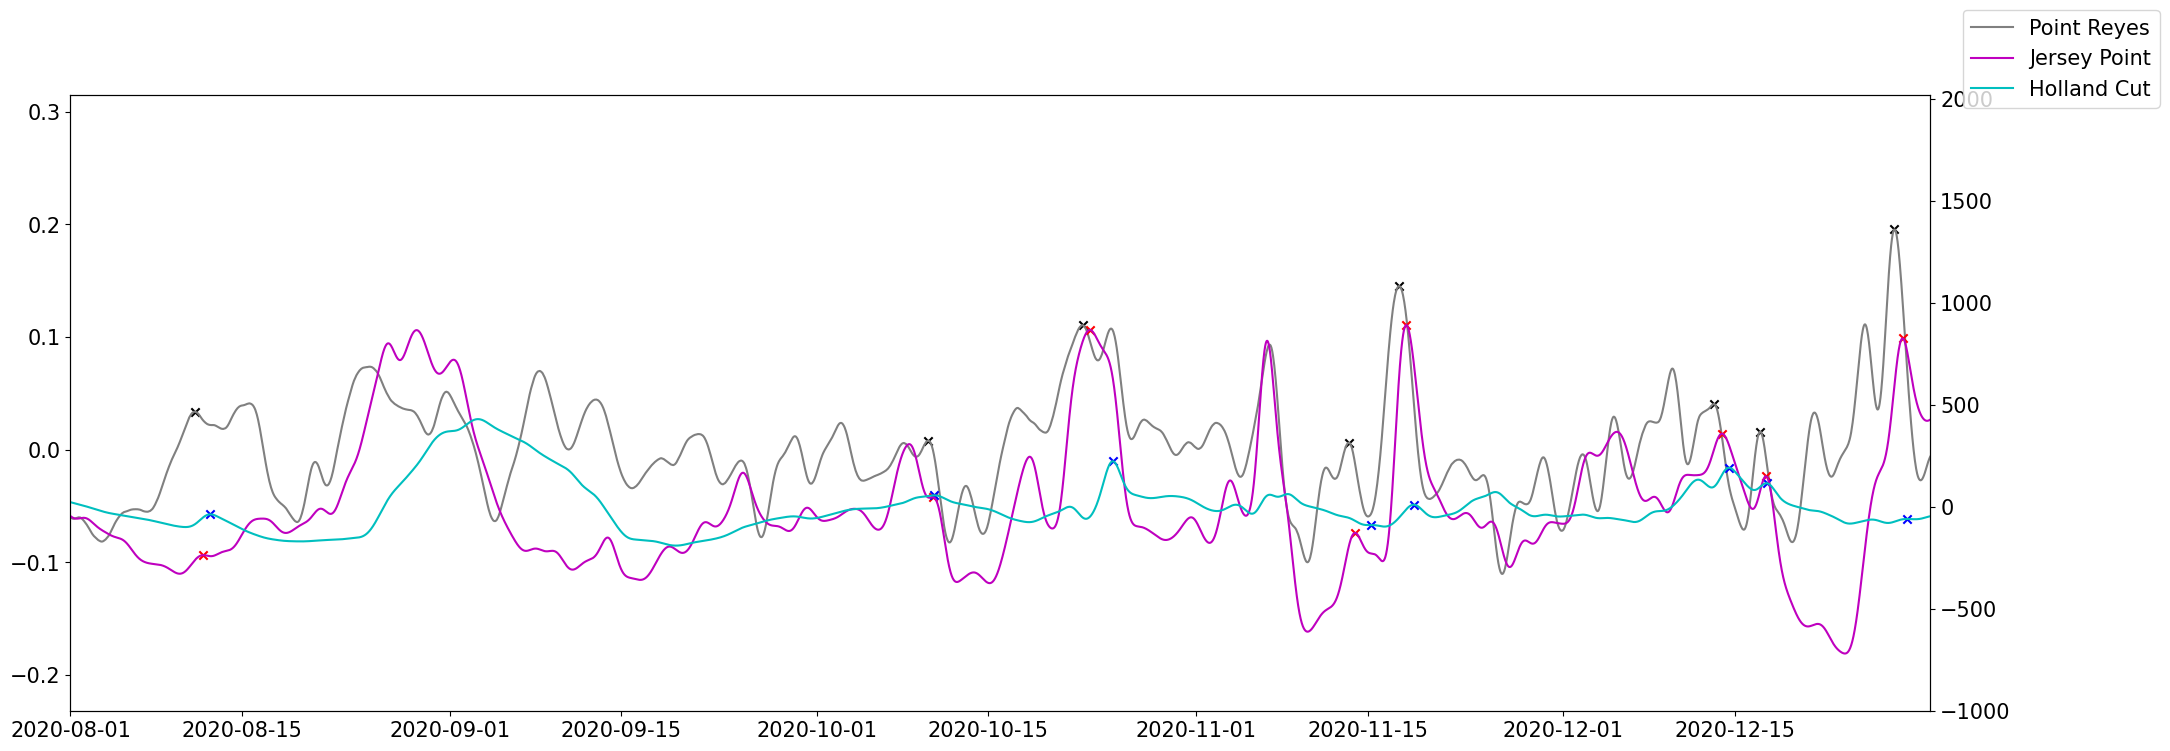

In [68]:
#Zoom into 2020
fig, ax =plt.subplots(sharey=True,figsize=(24,8))

ax.plot(pr_indices,df_f_wo21.pr.dropna(),color='grey', label="Point Reyes")
ax.scatter(df_f_wo21.datetime.loc[peak_pr24h_1], df_f_wo21.pr.loc[peak_pr24h_1],marker="x",color='k')
ax1=ax.twinx()
ax1.plot(df_f_wo21.jp,color='m',label="Jersey Point")
ax1.scatter(df_f_wo21.datetime.loc[peak_jp24h_1],df_f_wo21.jp.loc[peak_jp24h_1],marker="x",color='r')
ax1.plot(df_f_wo21.frk,color='c',label="Holland Cut")
ax1.scatter(df_f_wo21.datetime.loc[peak_frk24h],df_f_wo21.frk.loc[peak_frk24h],marker="x",color='b')
fig.legend()
ax.set_xlim([datetime(2020,8,1),datetime(2020,12,31)])
ax1.set_xlim([datetime(2020,8,1),datetime(2020,12,31)])
plt.show()

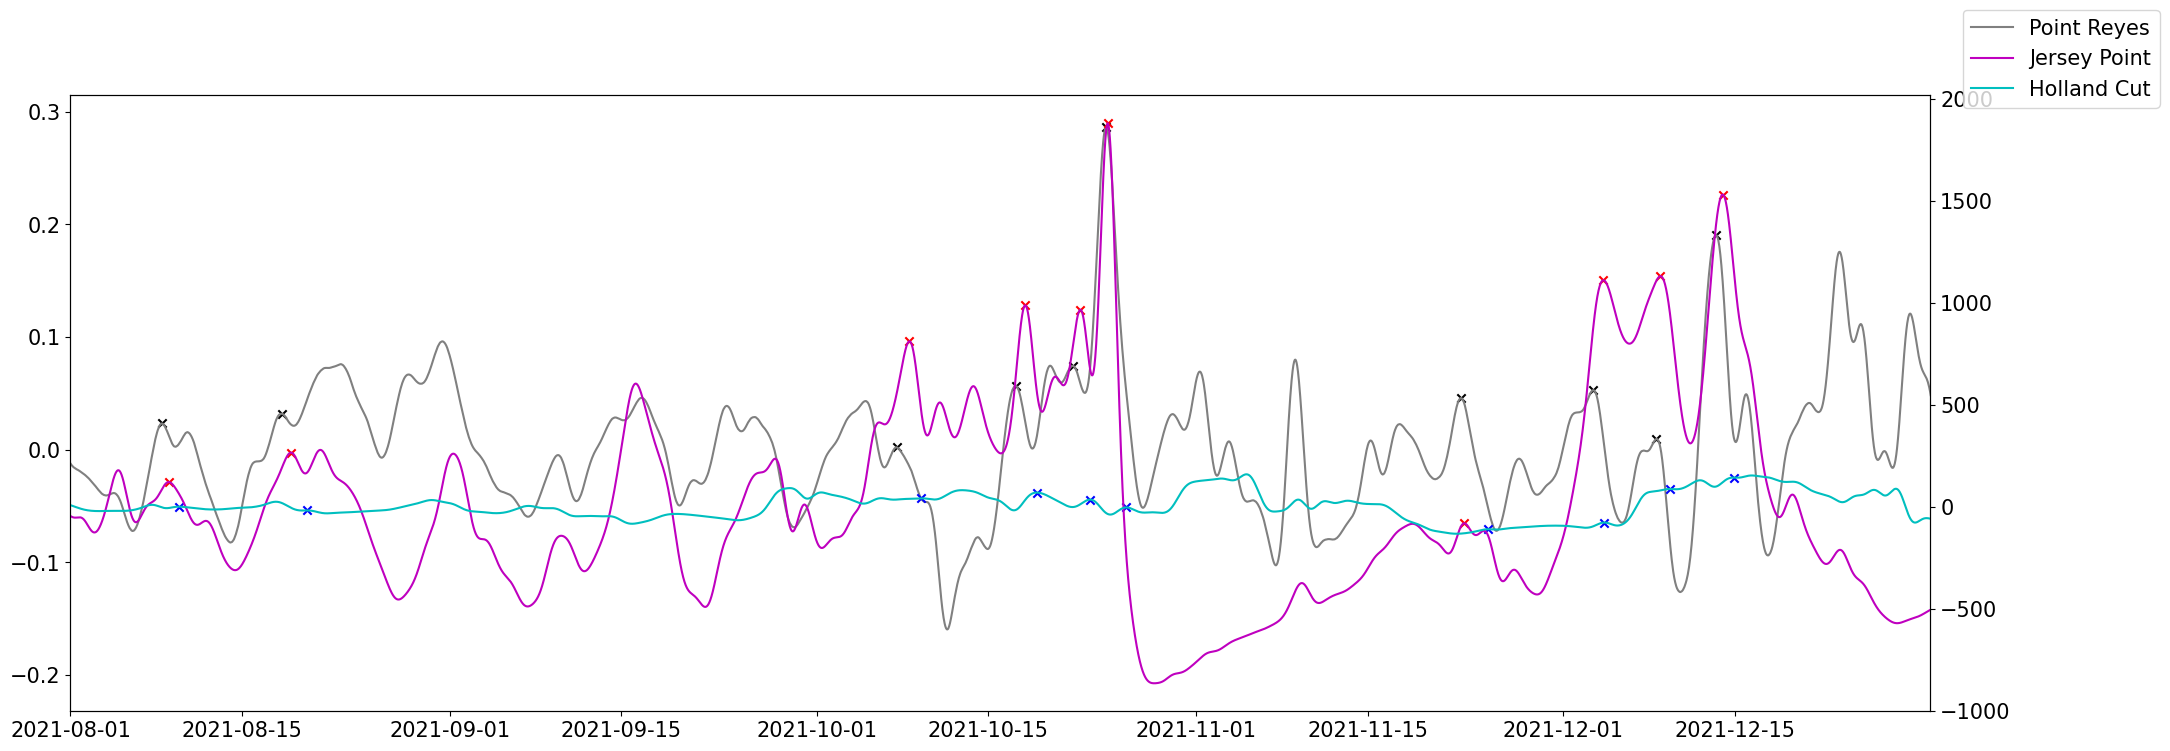

In [69]:
#Zoom into 2020
fig, ax =plt.subplots(sharey=True,figsize=(24,8))

ax.plot(pr_indices,df_f_wo21.pr.dropna(),color='grey', label="Point Reyes")
ax.scatter(df_f_wo21.datetime.loc[peak_pr24h_1], df_f_wo21.pr.loc[peak_pr24h_1],marker="x",color='k')
ax1=ax.twinx()
ax1.plot(df_f_wo21.jp,color='m',label="Jersey Point")
ax1.scatter(df_f_wo21.datetime.loc[peak_jp24h_1],df_f_wo21.jp.loc[peak_jp24h_1],marker="x",color='r')
ax1.plot(df_f_wo21.frk,color='c',label="Holland Cut")
ax1.scatter(df_f_wo21.datetime.loc[peak_frk24h],df_f_wo21.frk.loc[peak_frk24h],marker="x",color='b')
fig.legend()
ax.set_xlim([datetime(2021,8,1),datetime(2021,12,31)])
ax1.set_xlim([datetime(2021,8,1),datetime(2021,12,31)])
plt.show()

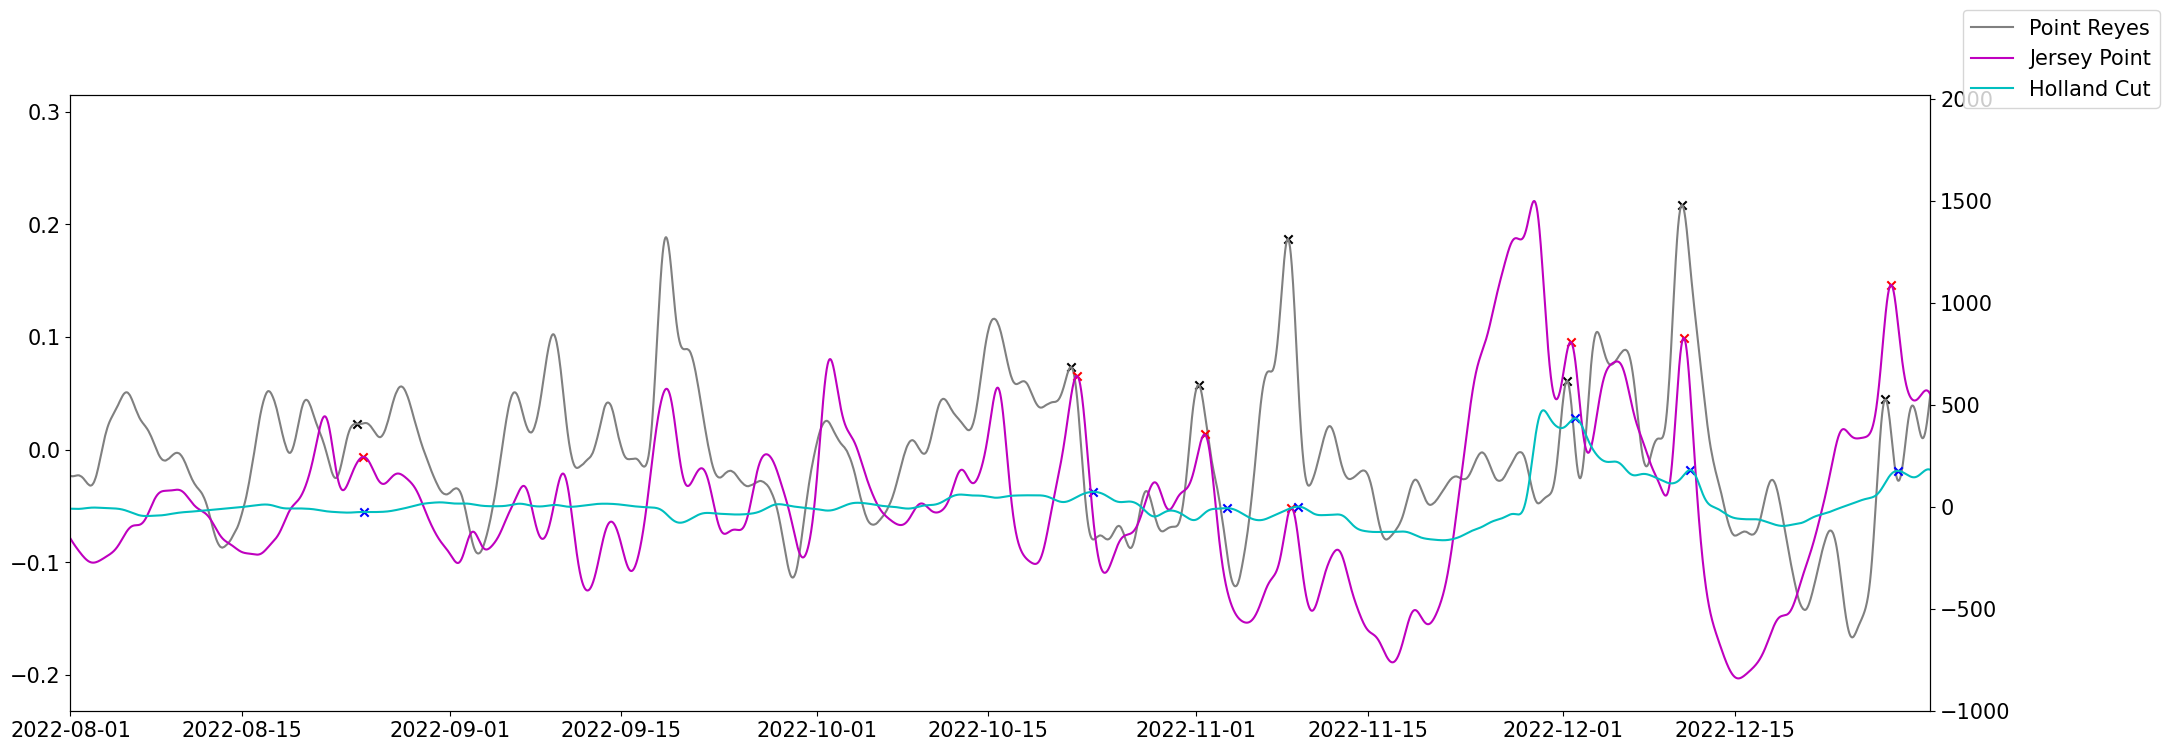

In [70]:
#Zoom into 2020
fig, ax =plt.subplots(sharey=True,figsize=(24,8))

ax.plot(pr_indices,df_f_wo21.pr.dropna(),color='grey', label="Point Reyes")
ax.scatter(df_f_wo21.datetime.loc[peak_pr24h_1], df_f_wo21.pr.loc[peak_pr24h_1],marker="x",color='k')
ax1=ax.twinx()
ax1.plot(df_f_wo21.jp,color='m',label="Jersey Point")
ax1.scatter(df_f_wo21.datetime.loc[peak_jp24h_1],df_f_wo21.jp.loc[peak_jp24h_1],marker="x",color='r')
ax1.plot(df_f_wo21.frk,color='c',label="Holland Cut")
ax1.scatter(df_f_wo21.datetime.loc[peak_frk24h],df_f_wo21.frk.loc[peak_frk24h],marker="x",color='b')
fig.legend()
ax.set_xlim([datetime(2022,8,1),datetime(2022,12,31)])
ax1.set_xlim([datetime(2022,8,1),datetime(2022,12,31)])
plt.show()

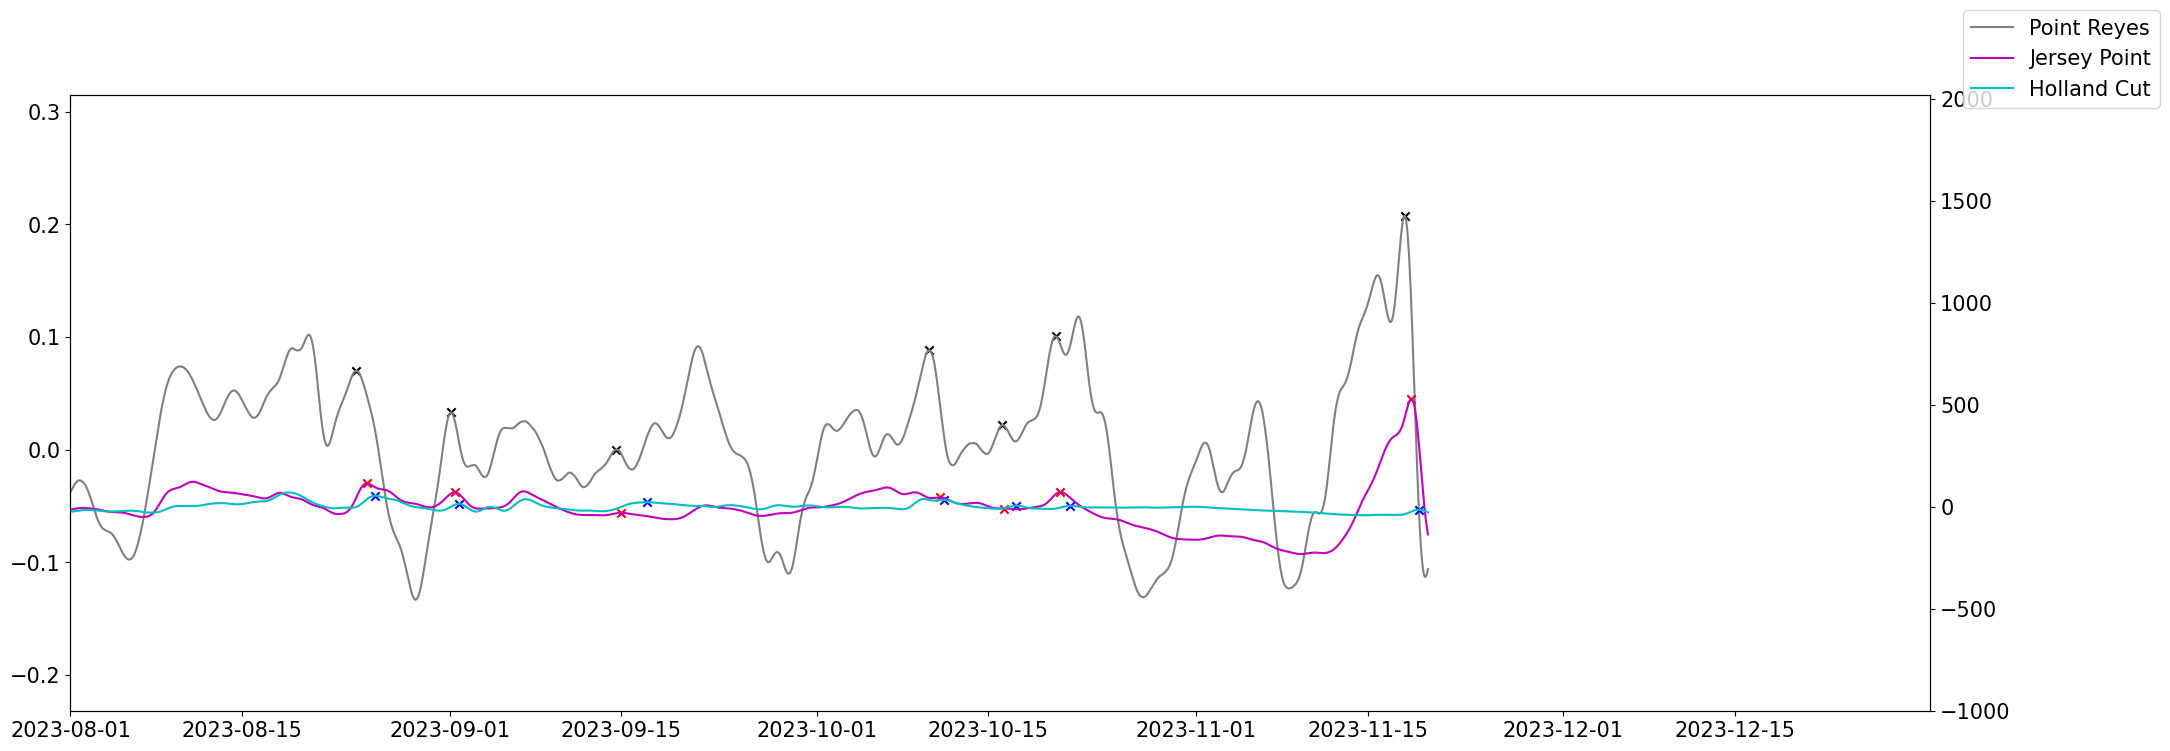

In [71]:
#Zoom into 2020
fig, ax =plt.subplots(sharey=True,figsize=(24,8))

ax.plot(pr_indices,df_f_wo21.pr.dropna(),color='grey', label="Point Reyes")
ax.scatter(df_f_wo21.datetime.loc[peak_pr24h_1], df_f_wo21.pr.loc[peak_pr24h_1],marker="x",color='k')
ax1=ax.twinx()
ax1.plot(df_f_wo21.jp,color='m',label="Jersey Point")
ax1.scatter(df_f_wo21.datetime.loc[peak_jp24h_1],df_f_wo21.jp.loc[peak_jp24h_1],marker="x",color='r')
ax1.plot(df_f_wo21.frk,color='c',label="Holland Cut")
ax1.scatter(df_f_wo21.datetime.loc[peak_frk24h],df_f_wo21.frk.loc[peak_frk24h],marker="x",color='b')
fig.legend()
ax.set_xlim([datetime(2023,8,1),datetime(2023,12,31)])
ax1.set_xlim([datetime(2023,8,1),datetime(2023,12,31)])
plt.show()

# Plot the events with river flow and low pressure events

# function to calculate intensities

In [72]:
def unit_area(x,y,properties,peaks,dt,labelstr,peaksubset,plotflag):
    
    #where dt is the time resolution of x in hours
    if len(peaksubset)< len(peaks):
        peakidx=np.in1d(peaks,peaksubset)
    else:
        peakidx=np.arange(0,len(peaks))
    left=properties["left_ips"][peakidx]
    right=properties["right_ips"][peakidx]
    lind=np.round(left).astype(int)
    rind=np.round(right).astype(int)
    areav=np.array([])
    if plotflag==1:
        fig,ax =plt.subplots(figsize=(24,8))
        ax.plot(x,y,color='grey',linewidth=3)

    peaky=np.array([])
    
    for p in np.arange(0,len(lind)):
        #print(p)
        peak=y[lind[p]:rind[p]]
        peaky=np.append(peaky,np.max(peak))
        total_area = trapz(peak,dx=0.5) #need to pass the values between the left and right
        #now subtract the area from 0 to the peak, straight line between y[lind[p]] and y[rind[p]], should be the same length as peak
        n_points=len(peak)
        peak_bottom=np.linspace(peak[0],peak[len(peak)-1],num=n_points,endpoint=True)
        area_bottom=trapz(peak_bottom,dx=dt) #dx is half an hour
        area=total_area-area_bottom
        #print(area)
        areav=np.append(areav, area)
        #check that we are selecting the right area of the peak
        if plotflag==1:
            ax.plot(x[lind[p]:rind[p]],peak,linestyle='--',color='c',linewidth=3)
            ax.plot(x[lind[p]:rind[p]],peak_bottom,linestyle='--',color='m')
            ax.vlines(x=x[lind],ymin=0,ymax=y[lind])
            ax.vlines(x=x[rind],ymin=0,ymax=y[rind])
        #30 minute time resolution = .5 hours
    dur=(rind-lind)*dt
    inten_u=areav/dur
    months_for_colors=x[lind].month
    print(len(peaksubset))
    print(len(peaky))
    if plotflag==1:
        ax.scatter(peaksubset,peaky,label=labelstr,marker="x",color='k',linewidth=2)
        #limit x axis to 1/5 of the time period
        ax.set_xlim([x[0],x[(np.rint(len(x)/10)).astype(int)]])
        plt.show()
    return inten_u, dur, months_for_colors #units of elevation in m X time in hours


In [73]:
def extract_prop(properties,peaks,peaksubset,unit,dt,plotflag):
    #where properties is the object output from find_peaks associated with
    #peaks, but the peaks passed here should have the same units as peaksubset
    #typically datetime or unitless index
    #unit is the unit of the y data passed to find_peaks, either mS/cm^3 or 
    # m
    #dt is the amount of time between samples passed to find_peaks in hours
    #e.g. for the salinity data it should be 0.25 but for the SCHA pt reyes data 0.5
    if len(peaks)>len(peaksubset):
        peakidx=np.in1d(peaks,peaksubset)
    else:
        peakidx=np.arange(0,len(peaks))
    prominences=properties["prominences"][peakidx]
    widths=properties["widths"][peakidx]
    if plotflag==1:
        fig, ax = plt.subplots(1,2,layout='constrained')
        ax[0].hist(prominences)
        ax[1].hist(widths*dt)
        ax[0].set_xlabel('Peak prominence ['+unit+']')
        ax[1].set_xlabel('Peak width [h]')
    return prominences, widths

# intensity duration for the events that make it to holland cut

80
80


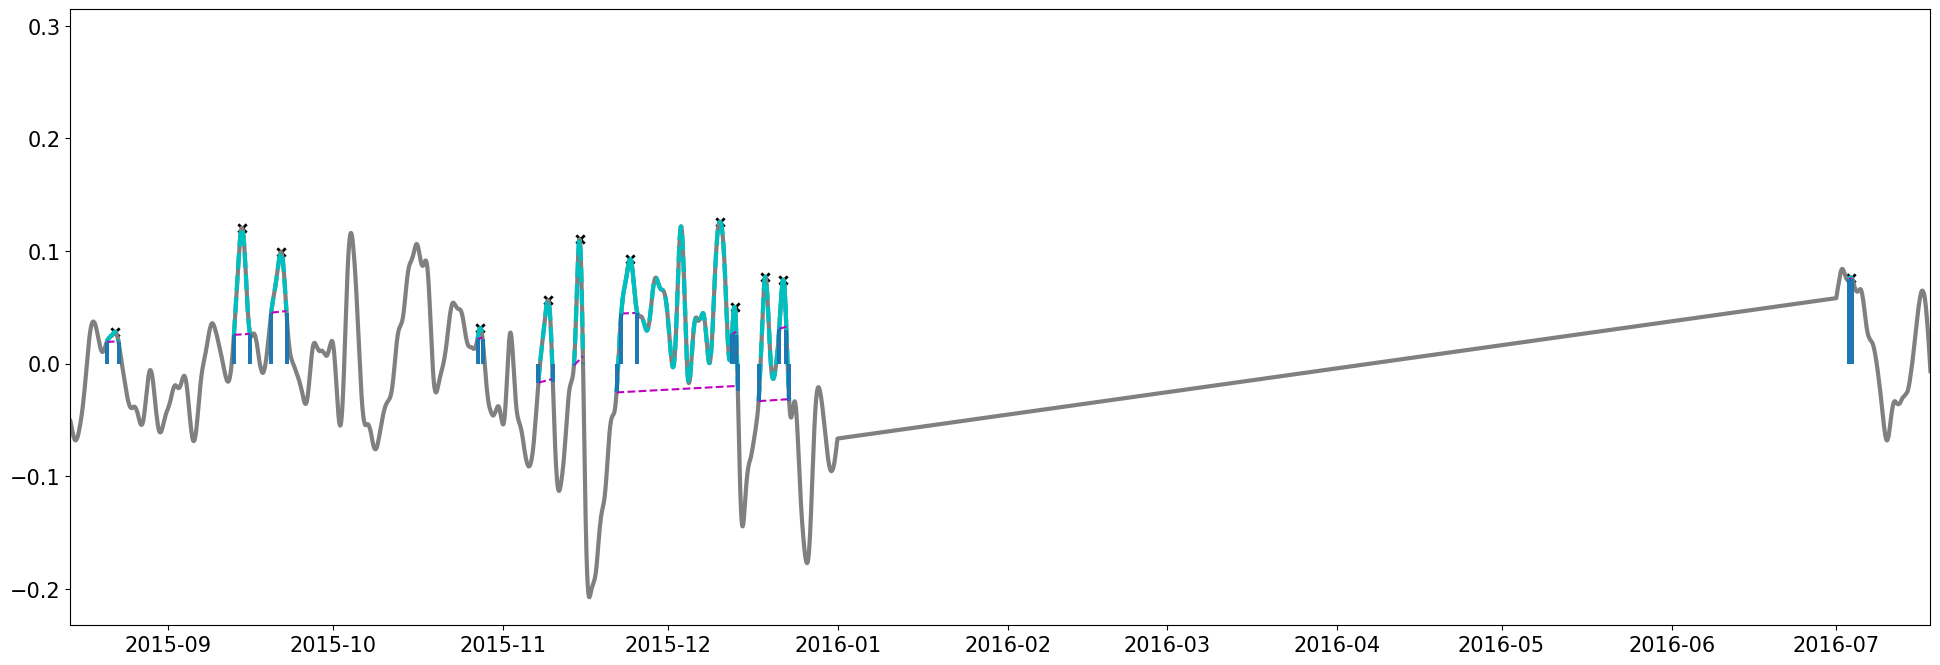

80
80
80
79


In [74]:
x_pr=df_f_wo21.pr.dropna().index
y_pr=df_f_wo21.pr.dropna().values
#unit_area(x,y,properties,peaks,dt,labelstr,peaksubset)
inten_u_pr, dur_pr, mfc_pr = unit_area(x_pr,y_pr,propertiespr,pr_indices[peakspr],0.5,'pt reyes',peak_pr24h_1,1)
x_jp=df_f_wo21.jp.dropna().index
y_jp=df_f_wo21.jp.dropna().values
inten_u_jp, dur_jp, mfc_jp = unit_area(x_jp,y_jp,propertiesjp,jp_indices[peaksjp],0.25,'Jersey Point',peak_jp24h_1,0)
x_frk=df_f_wo21.frk.dropna().index
y_frk=df_f_wo21.frk.dropna().values
inten_u_frk, dur_frk, mfc_frk = unit_area(x_frk,y_frk,propertiesfrk,frk_indices[peaksfrk],0.25,'Holland Cut',peak_frk24h,0)

# x_frk=df_f_wo21.frk.dropna().index
# y_frk=df_f_wo21.frk.dropna().values
# inten_u_frk, dur_frk, mfc_frk = unit_area(x_frk,y_frk,propertiesfrk,peaksfrk,0.5,'Holland Cut',peak_frk24h)

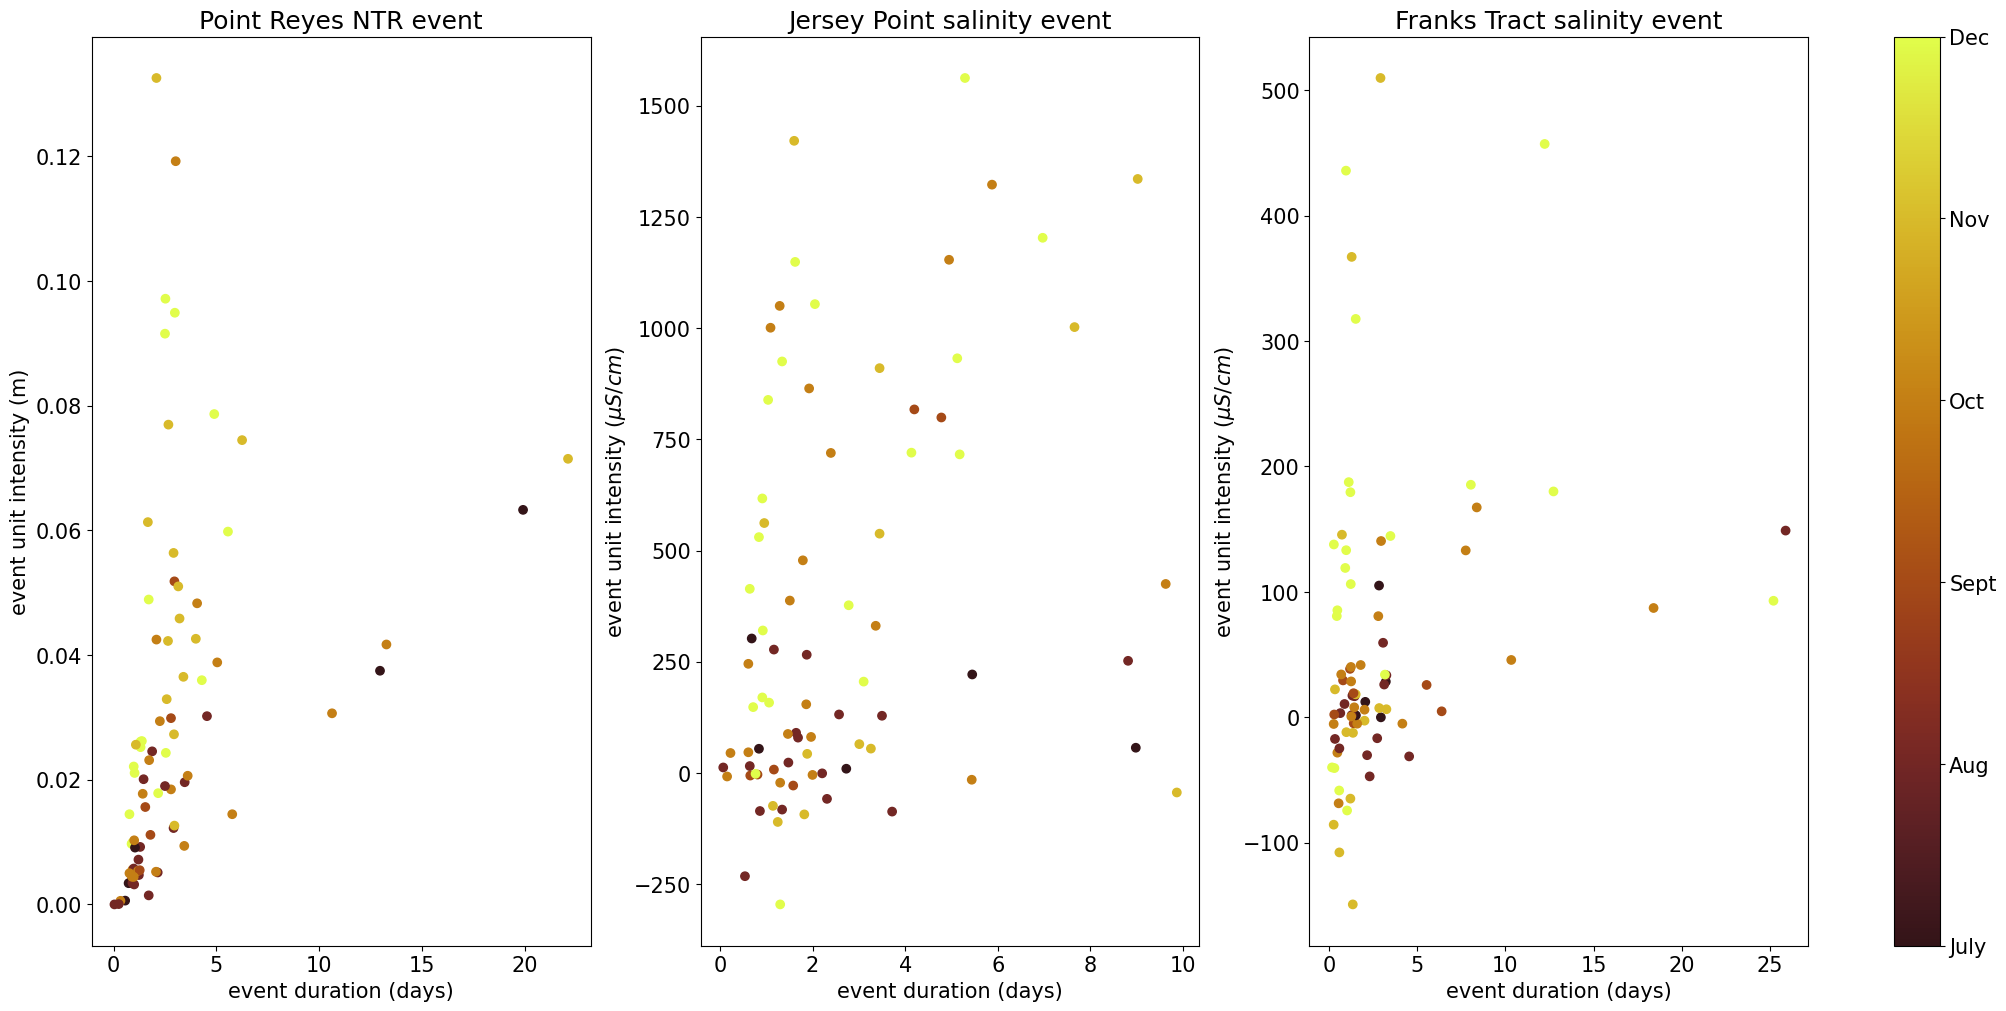

In [77]:
# Plot intensity- duration for each location
#add colorbar
fig, ax = plt.subplots(1,3,layout='constrained',figsize= (20,10))
# setting font sizeto 30
plt.rcParams.update({'font.size': 15})
pts0=ax[0].scatter(dur_pr/24,inten_u_pr,c=mfc_pr,cmap=cmocean.cm.solar)
ax[0].set_xlabel('event duration (days)')
ax[0].set_ylabel('event unit intensity (m)')
#ax[1].set_xlim(0,12)
ax[0].set_title('Point Reyes NTR event')
# cbar=fig.colorbar(pts0, ax=ax)
# cbar.set_ticks(ticks=np.arange(7,13), labels=['July','Aug','Sept','Oct','Nov','Dec'])

pts1=ax[1].scatter(dur_jp/24,inten_u_jp,c=mfc_jp,cmap=cmocean.cm.solar)
ax[1].set_xlabel('event duration (days)')
ax[1].set_ylabel('event unit intensity ($\mu S/cm$)')
#ax[1].set_xlim(0,12)
ax[1].set_title('Jersey Point salinity event')

pts2=ax[2].scatter(dur_frk/24,inten_u_frk,c=mfc_frk,cmap=cmocean.cm.solar)
ax[2].set_xlabel('event duration (days)')
ax[2].set_ylabel('event unit intensity ($\mu S/cm$)')
#ax[1].set_xlim(0,12)
ax[2].set_title('Franks Tract salinity event')


cbar=fig.colorbar(pts2, ax=ax)
cbar.set_ticks(ticks=np.arange(7,13), labels=['July','Aug','Sept','Oct','Nov','Dec'])
plt.show()

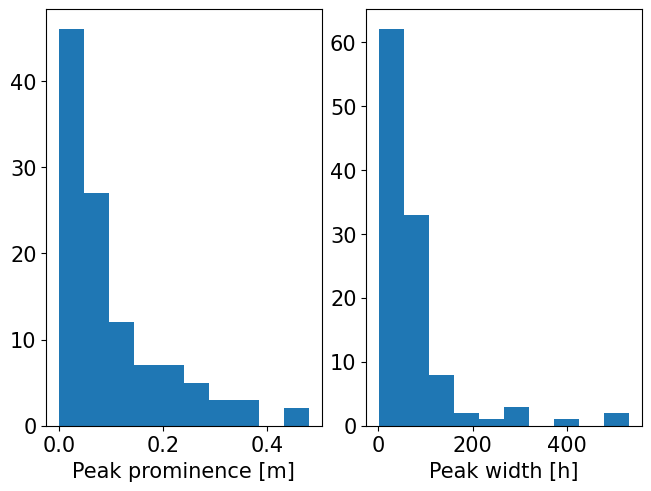

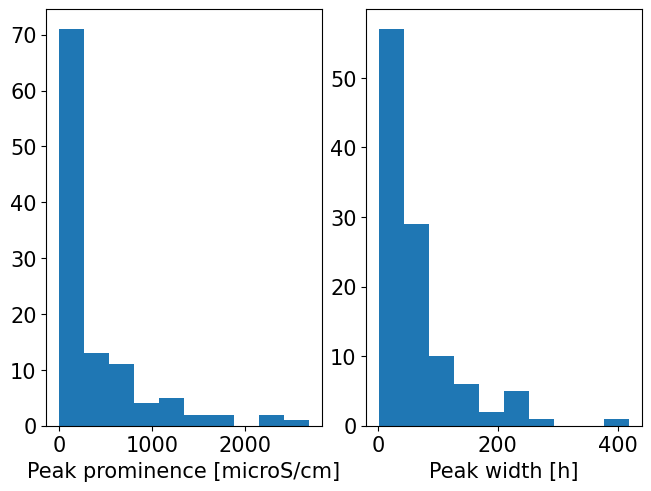

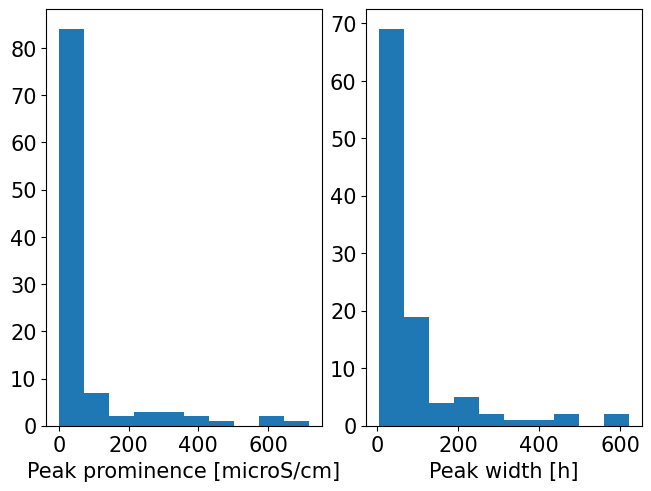

In [38]:
prominencespr, widthspr = extract_prop(propertiespr,pr_indices[peakspr],peak_pr24h_1,'m',0.5,1)
prominencesjp, widthsjp = extract_prop(propertiesjp,jp_indices[peaksjp],peak_jp24h_1,'microS/cm',0.25,1)
prominencesfrk, widthsfrk = extract_prop(propertiesfrk,frk_indices[peaksfrk],peak_frk24h,'microS/cm',0.25,1)

# Lags between different locations?

In [78]:
#subtract the dates in each peak_*24h
jp_lags=(peak_jp24h_1-peak_pr24h_1).astype(np.float)/(10**9*60*60) #convert from ns to h
frk_lags=(peak_frk24h-peak_pr24h_1).astype(np.float)/(10**9*60*60) #convert from ns to h

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel pac

Text(0.5, 0, 'Lag [h] P Reyes and Franks Tract')

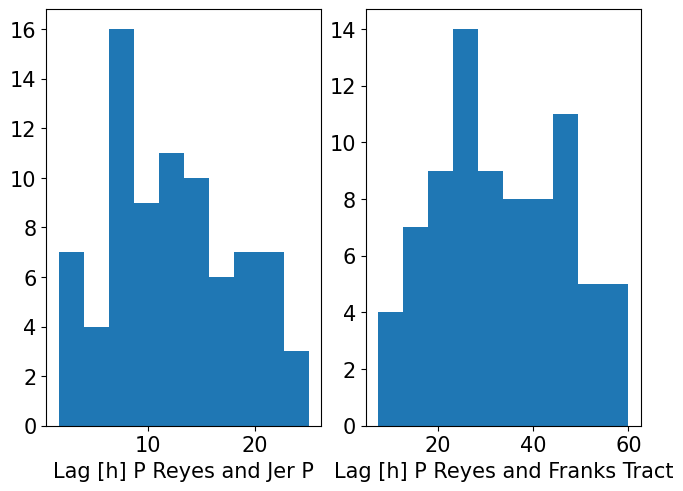

In [80]:
fig, ax =plt.subplots(1,2,layout='constrained')

ax[0].hist(jp_lags)
ax[1].hist(frk_lags)
ax[0].set_xlabel('Lag [h] P Reyes and Jer P')
ax[1].set_xlabel('Lag [h] P Reyes and Franks Tract')

In [88]:
# Intensity versus lag for only the non duplicated peaks (lag associated with the first one)
all_ind=np.arange(0,80)
unq_ind_frk=np.setdiff1d(all_ind,dup_ind)
#unq_ind_jp=np.setdiff1d(all_ind,75)
len(unq_ind_frk)
#len(unq_ind_jp)

79

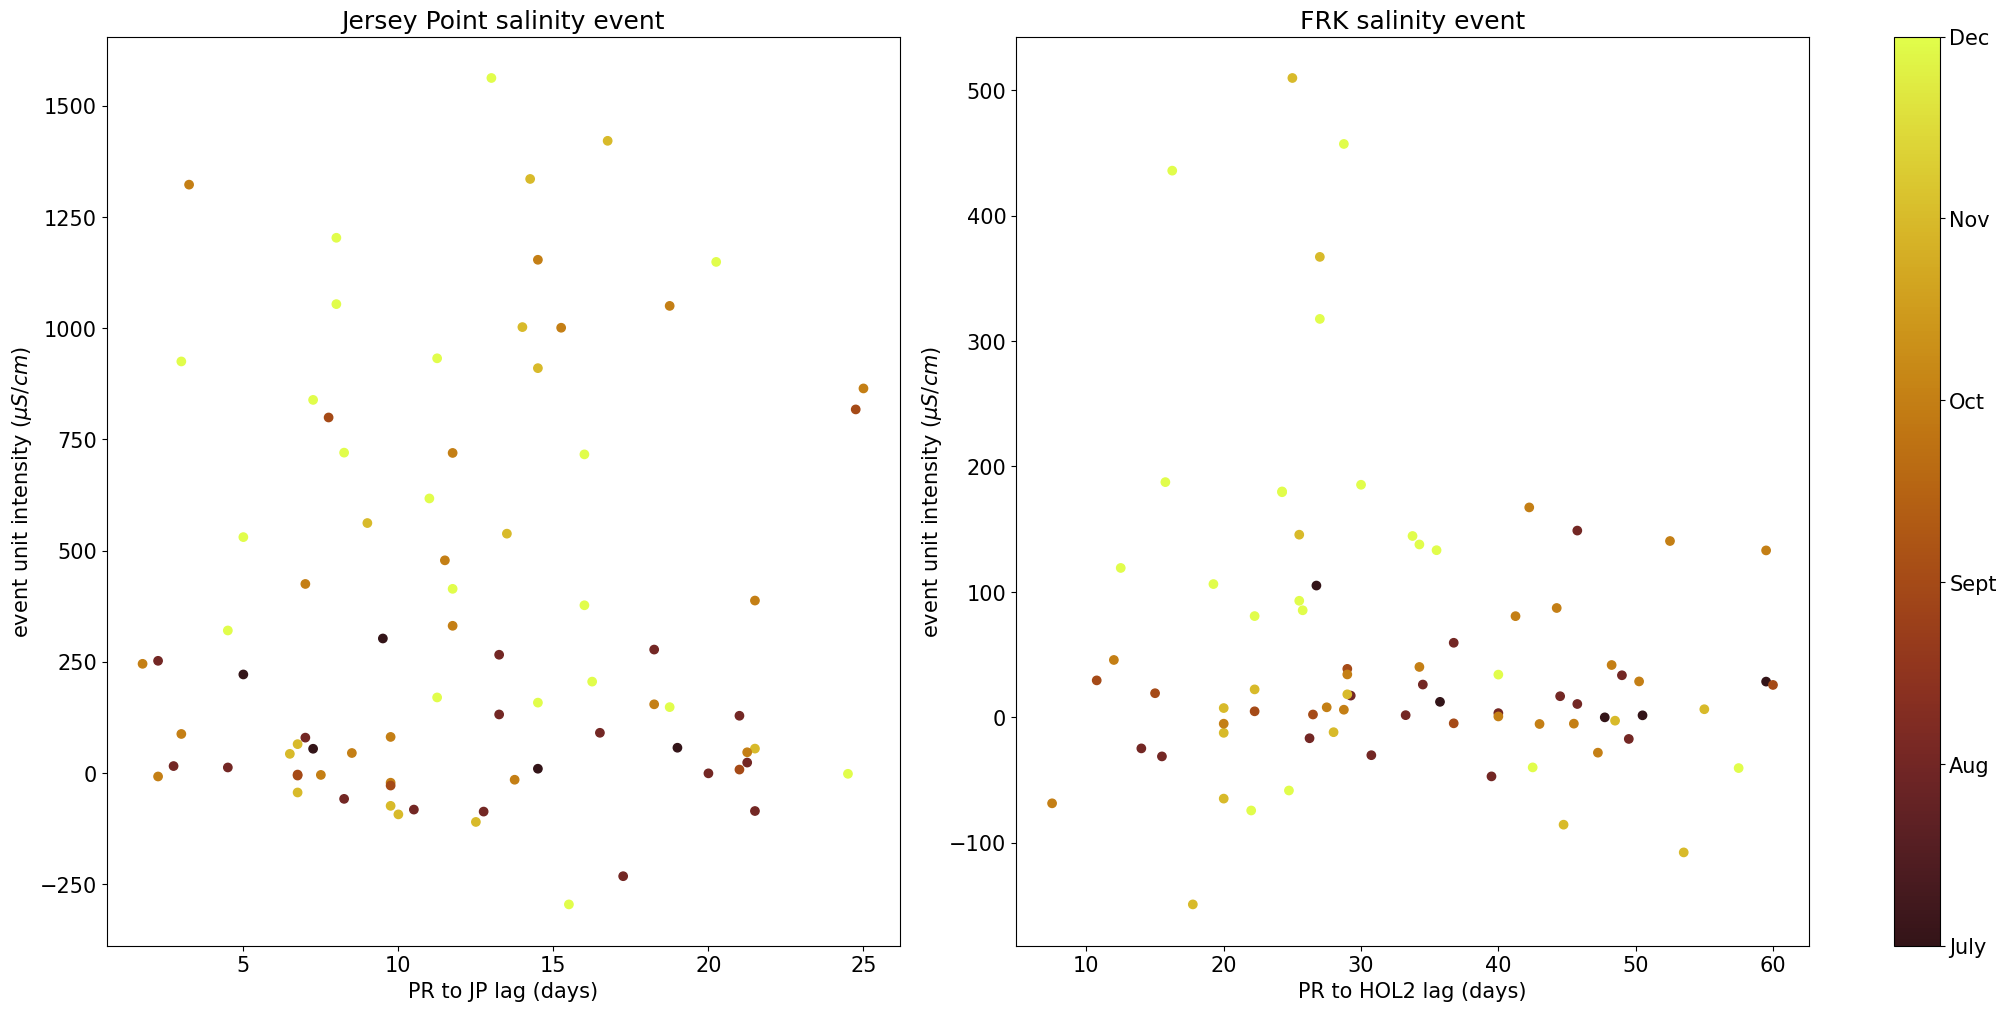

In [90]:
# what about lag versus intensity
# Plot intensity- duration for each location
#add colorbar
fig, ax = plt.subplots(1,2,layout='constrained',figsize= (20,10))
# setting font sizeto 30
plt.rcParams.update({'font.size': 15})
# pts0=ax[0].scatter(dur_pr/24,inten_u_pr,c=mfc_pr,cmap=cmocean.cm.solar)
# ax[0].set_xlabel('event duration (days)')
# ax[0].set_ylabel('event unit intensity (m)')
# #ax[1].set_xlim(0,12)
# ax[0].set_title('Point Reyes NTR event')
# # cbar=fig.colorbar(pts0, ax=ax)
# # cbar.set_ticks(ticks=np.arange(7,13), labels=['July','Aug','Sept','Oct','Nov','Dec'])

#only 75 is duplicated for jp
pts1=ax[0].scatter(jp_lags,inten_u_jp,c=mfc_jp,cmap=cmocean.cm.solar)
ax[0].set_xlabel('PR to JP lag (days)')
ax[0].set_ylabel('event unit intensity ($\mu S/cm$)')
#ax[1].set_xlim(0,12)
ax[0].set_title('Jersey Point salinity event')

pts2=ax[1].scatter(frk_lags[unq_ind_frk],inten_u_frk,c=mfc_frk,cmap=cmocean.cm.solar)
ax[1].set_xlabel('PR to HOL2 lag (days)')
ax[1].set_ylabel('event unit intensity ($\mu S/cm$)')
#ax[1].set_xlim(0,12)
ax[1].set_title('FRK salinity event')


cbar=fig.colorbar(pts2, ax=ax)
cbar.set_ticks(ticks=np.arange(7,13), labels=['July','Aug','Sept','Oct','Nov','Dec'])
plt.show()

# Find the start and end days of the point reyes events

In [41]:
# make a dataframe with the peak date, start time, and end time and write to a csv
def write_peak_dates(properties,peaks,peaksubset,timevector,writepath=np.nan):
    #where properties is the object output from find_peaks associated with
    #peaks, but the peaks passed here should have the same units as peaksubset
    #typically datetime or unitless index
    #unit is the unit of the y data passed to find_peaks, either mS/cm^3 or 
    # m
    #dt is the amount of time between samples passed to find_peaks in hours
    #e.g. for the salinity data it should be 0.25 but for the SCHA pt reyes data 0.5
    if len(peaks)>len(peaksubset):
        peakidx=np.in1d(peaks,peaksubset) #true false
    else:
        peakidx=np.arange(0,len(peaks))
    #print(peaks)
    left=properties["left_ips"][peakidx]
    right=properties["right_ips"][peakidx]
    #print(np.rint(left).astype(int))
    # left and right are interpolated positions,to map these indices back to datetimes from timevector need to round to nearest integer
    starttime=timevector[np.rint(left).astype(int)]
    endtime=timevector[np.rint(right).astype(int)]
    datearray=np.c_[peaksubset,starttime,endtime]
    peakdatesdf=pd.DataFrame(data=datearray,columns={'Max','Start','End'})
    if pd.isnull(writepath)==False:
        peakdatesdf.to_csv(writepath)
    return peakdatesdf


In [42]:
peakdatespr = write_peak_dates(propertiespr,pr_indices[peakspr],peak_pr24h_1,pr_indices,'/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/pr_peaks_2025_12_18.csv')
peakdatespr

,Max,End,Start
0,2015-08-22 07:00:00,2015-08-20 19:30:00,2015-08-22 23:00:00
1,2015-09-14 10:00:00,2015-09-12 23:30:00,2015-09-15 22:30:00
2,2015-09-21 13:30:00,2015-09-19 18:30:00,2015-09-22 13:30:00
3,2015-10-27 21:00:00,2015-10-27 09:00:00,2015-10-28 07:00:00
4,2015-11-09 05:00:00,2015-11-07 11:00:00,2015-11-10 02:30:00
...,...,...,...
107,2023-10-10 03:30:00,2023-10-08 20:00:00,2023-10-11 02:00:00
108,2023-10-13 19:00:00,2023-10-13 01:30:00,2023-10-14 08:00:00
109,2023-10-16 04:00:00,2023-10-15 17:30:00,2023-10-16 17:00:00
110,2023-10-20 12:00:00,2023-10-20 03:30:00,2023-10-20 22:00:00


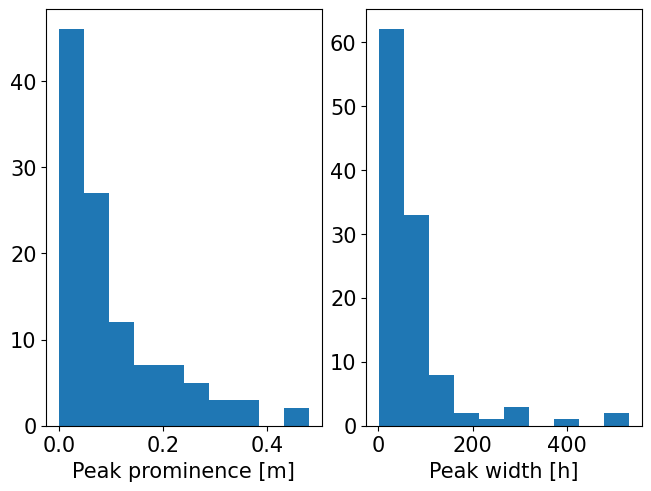

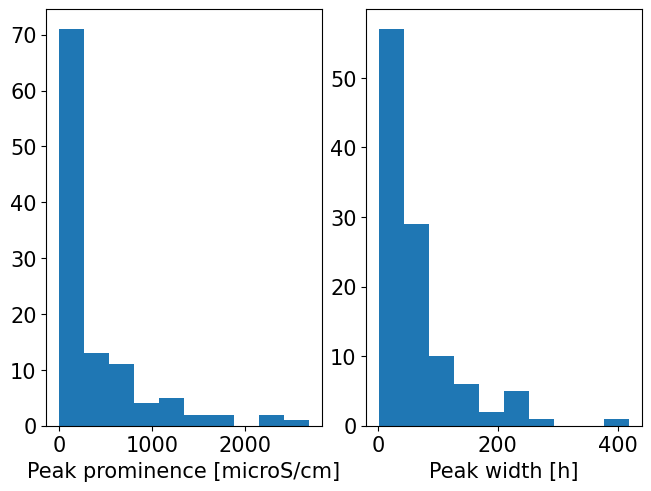

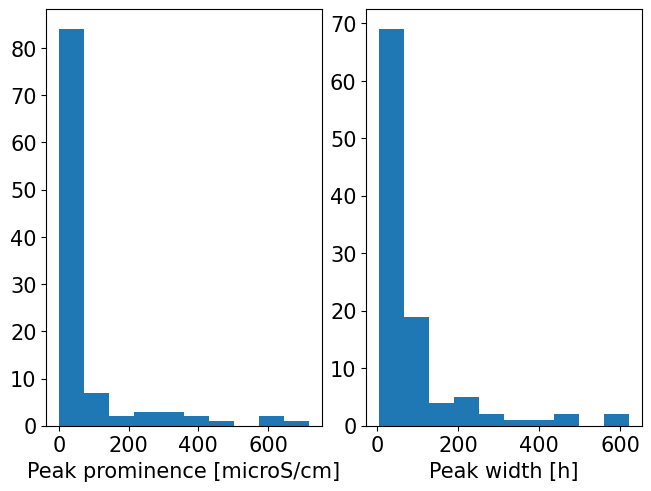

In [43]:
prominencespr, widthspr = extract_prop(propertiespr,pr_indices[peakspr],peak_pr24h_1,'m',0.5,1)
prominencesjp, widthsjp = extract_prop(propertiesjp,jp_indices[peaksjp],peak_jp24h_1,'microS/cm',0.25,1)
prominencesfrk, widthsfrk = extract_prop(propertiesfrk,frk_indices[peaksfrk],peak_frk24h,'microS/cm',0.25,1)